In [1]:
import sys

import numpy as np
import pandas as pd
import shap

/Users/zachariebuisson/Documents/GitHub/mlexplainer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

sys.path.append("../")

In [3]:
from mlexplainer import BinaryMLExplainer, MultilabelMLExplainer

In [4]:
dataframe = pd.read_csv('../tests/resources/samples/df_nba_rookie.csv')
dataframe.shape[0]

1340

In [5]:
dataframe["is_ok_3pts"] = dataframe["3PA"].apply(lambda u: "2 +" if u > 2 else "Entre 0 et 1" if u > 1 else "Moins de 1")

dataframe["is_ok_3pts"] = dataframe["is_ok_3pts"].astype("category")
dataframe["is_ok_3pts"].value_counts()

is_ok_3pts
Moins de 1      972
Entre 0 et 1    192
2 +             176
Name: count, dtype: int64

### Réalisation d'un modèle de base

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
dataframe['3P%_2'] = dataframe['3P%'].apply(lambda u: np.nan if u<15 else u)
del dataframe["Name"]

In [8]:
target = 'TARGET_5Yrs'
selected_features = [c for c in dataframe if (c != target) and c not in ["Name"]]

### Séparation en X et y ###
X, y = dataframe, dataframe[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
fitted_model = model.fit(X_train[selected_features], y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 560, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1815
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624303 -> initscore=0.507854
[LightGBM] [Info] Start training from score 0.507854


In [10]:
binary_explainer = BinaryMLExplainer(model=fitted_model, x_train=X_train[selected_features], 
y_train=y_train, features=selected_features)

/Users/zachariebuisson/Documents/GitHub/mlexplainer/.venv/lib/python3.11/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


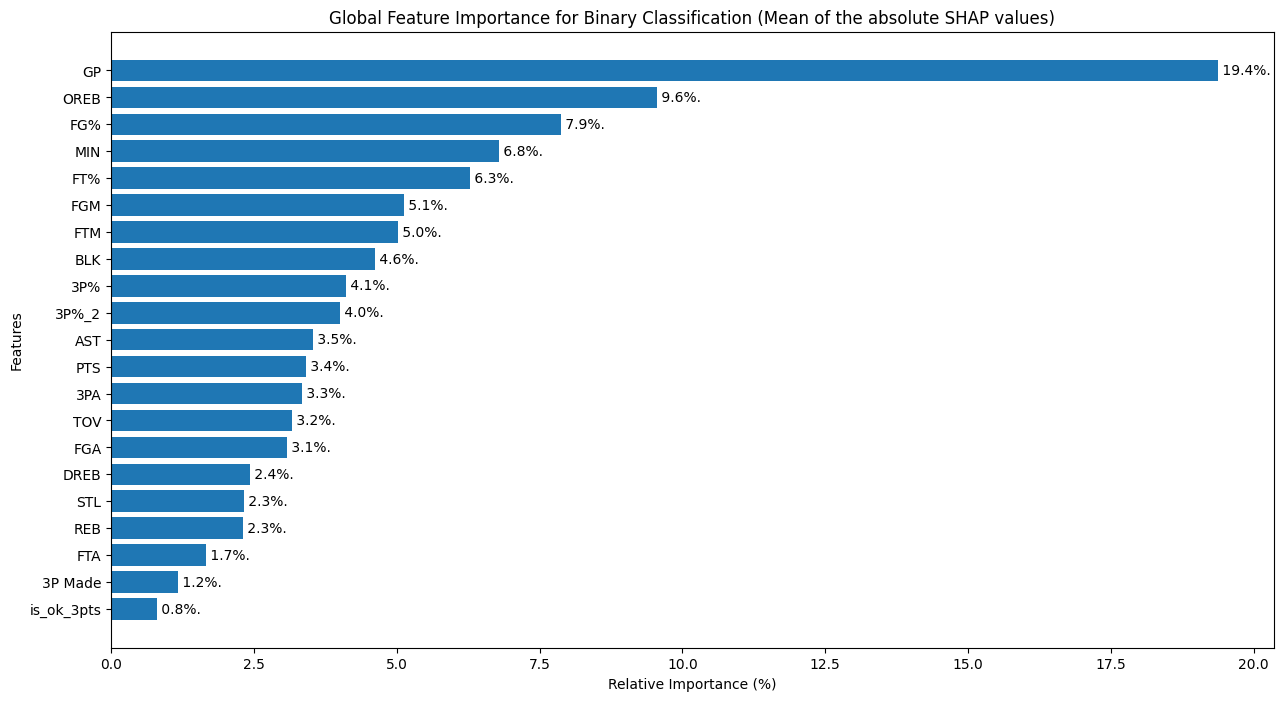

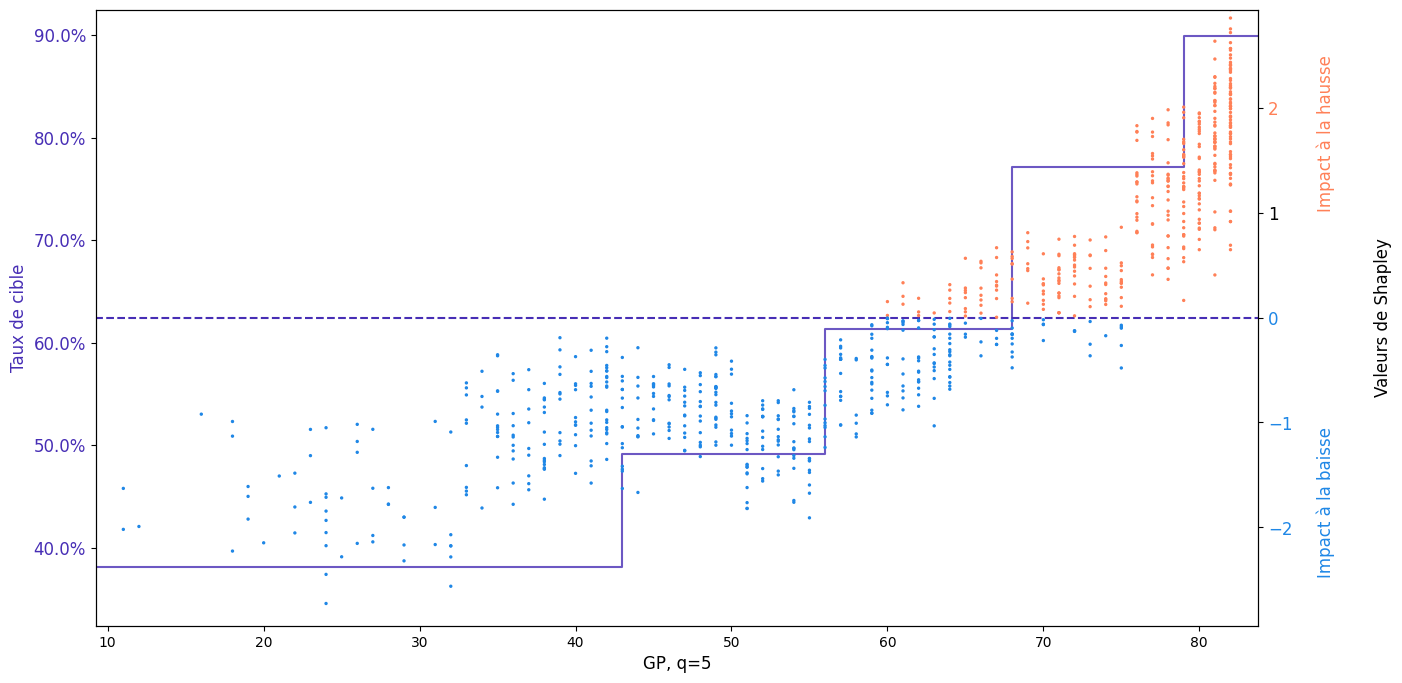

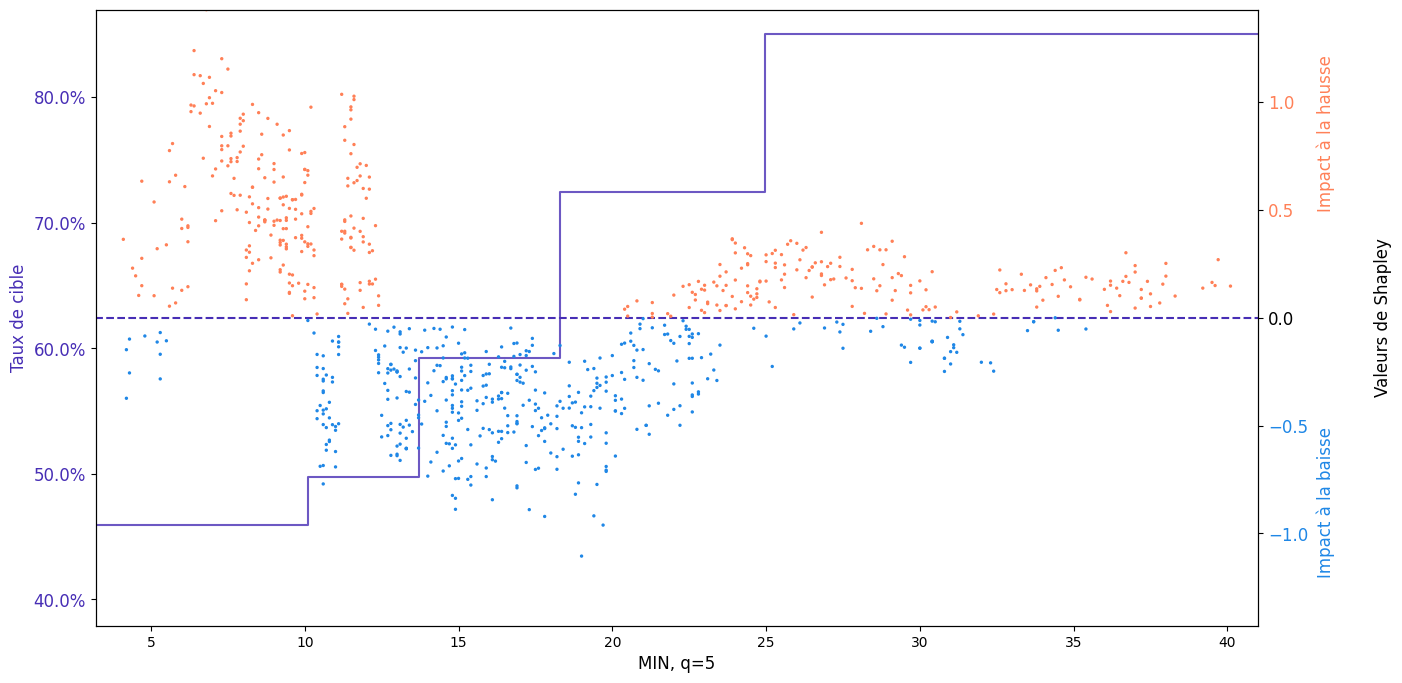

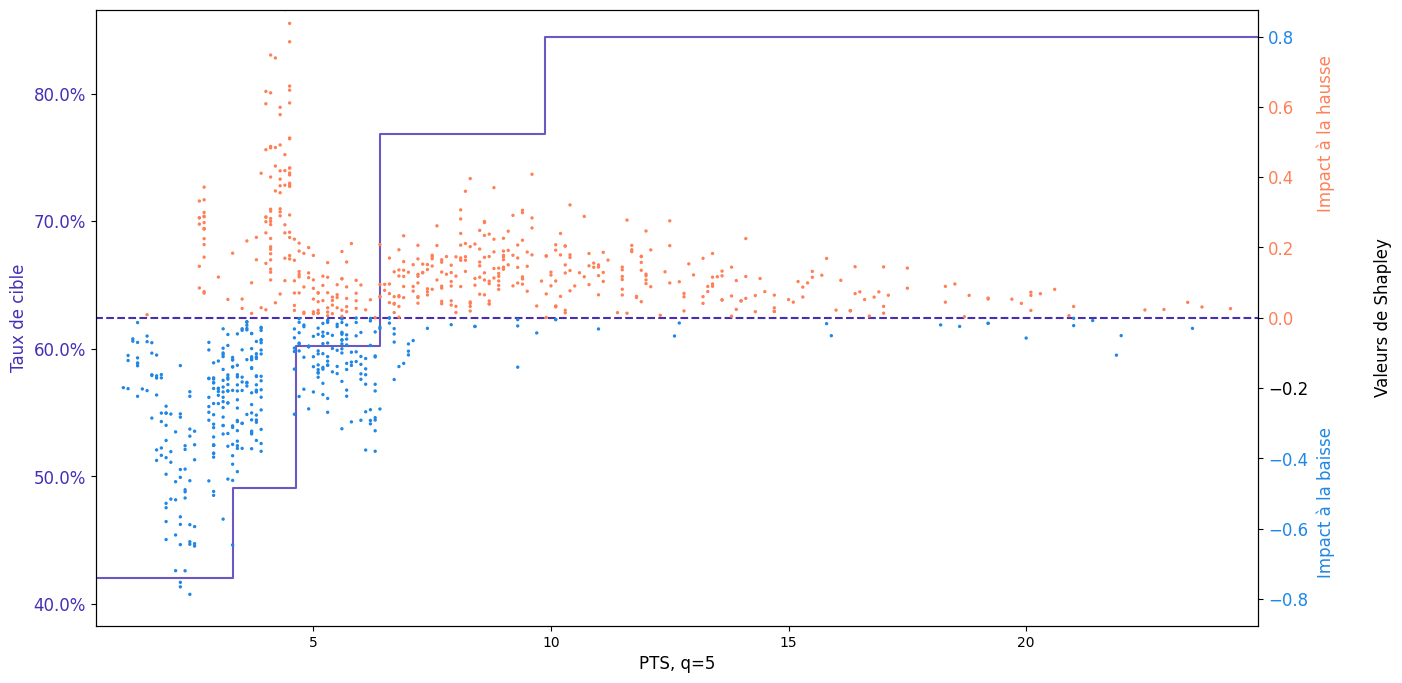

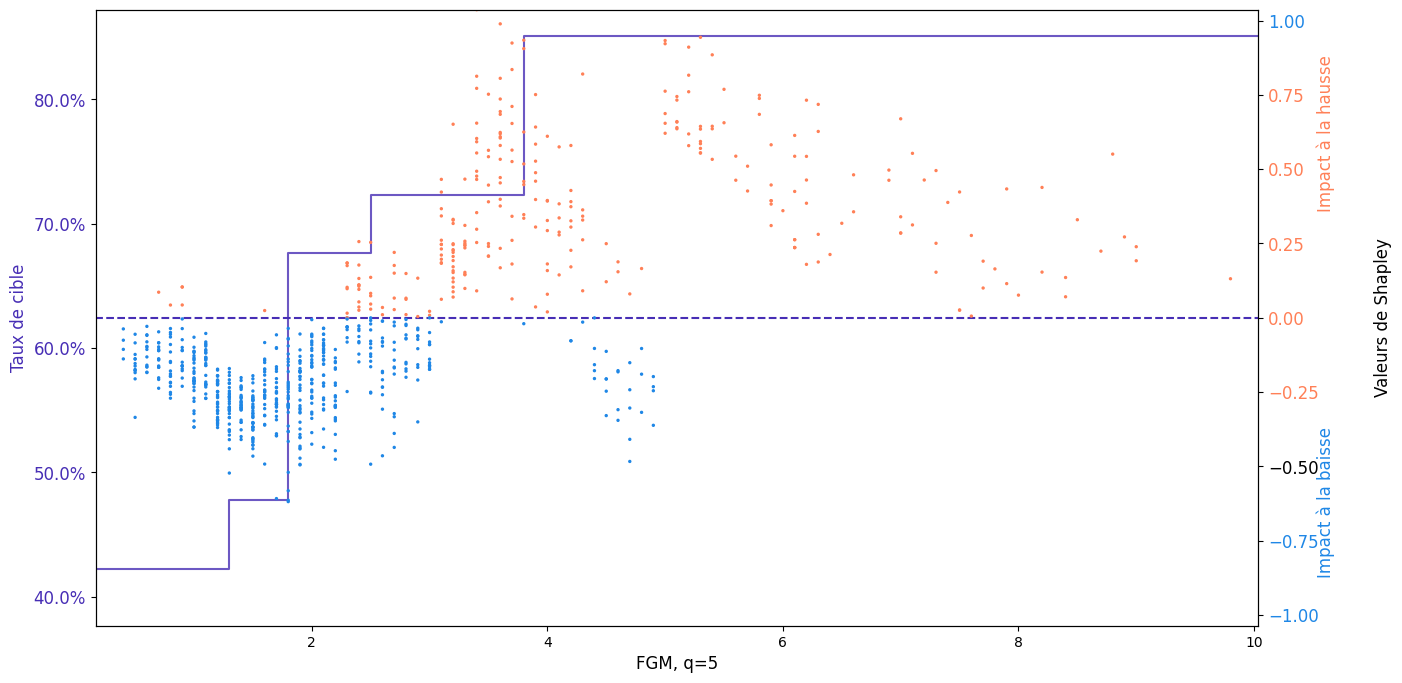

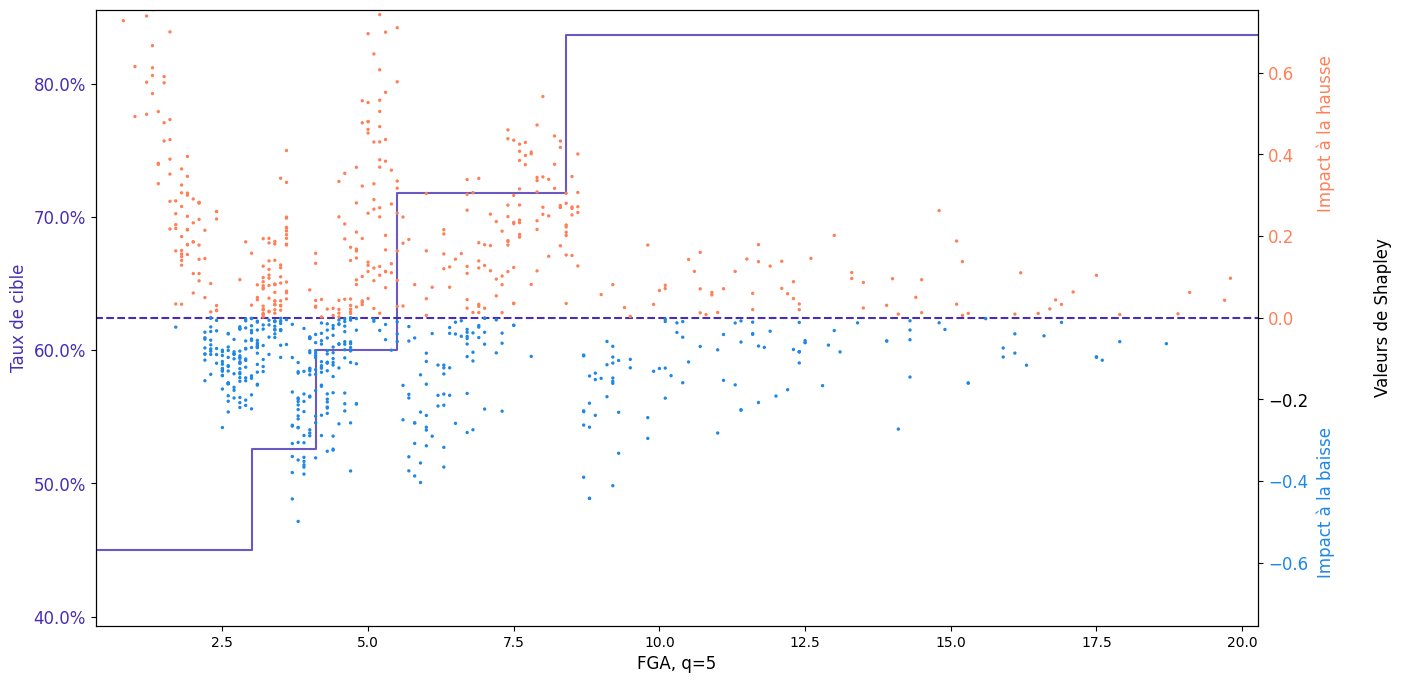

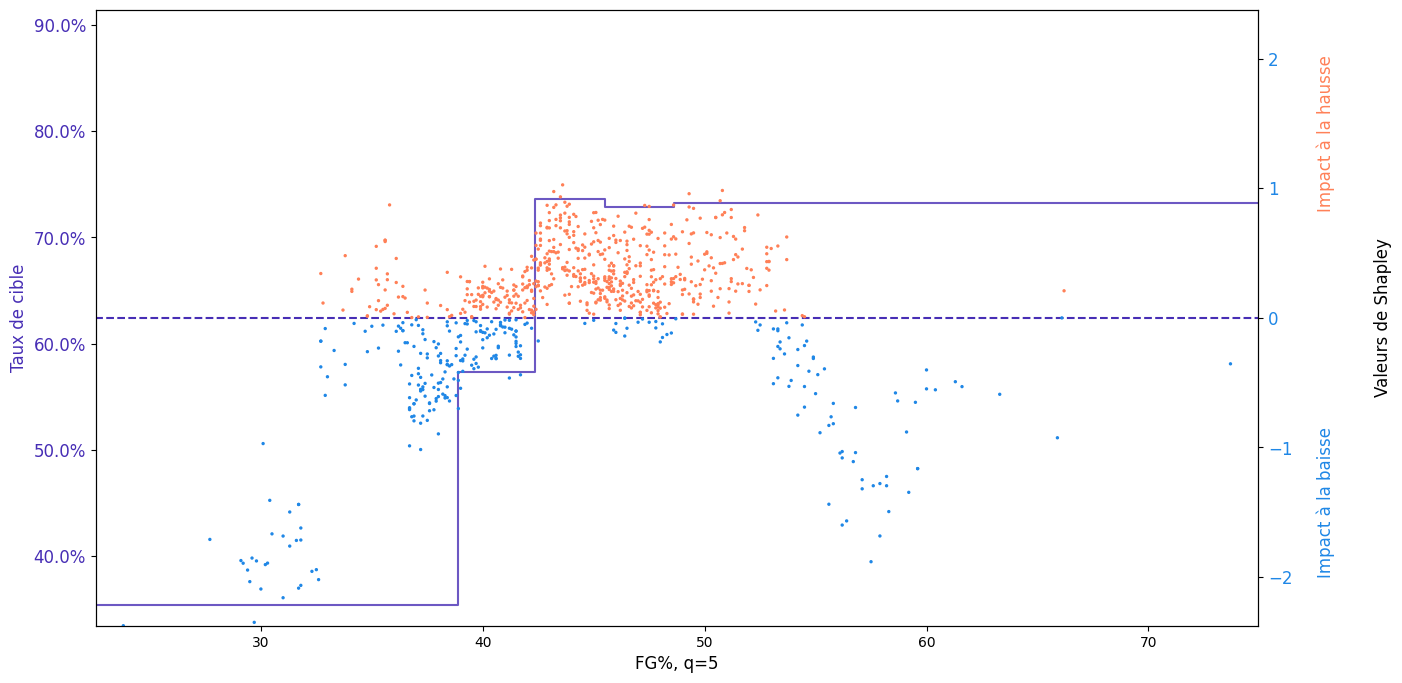

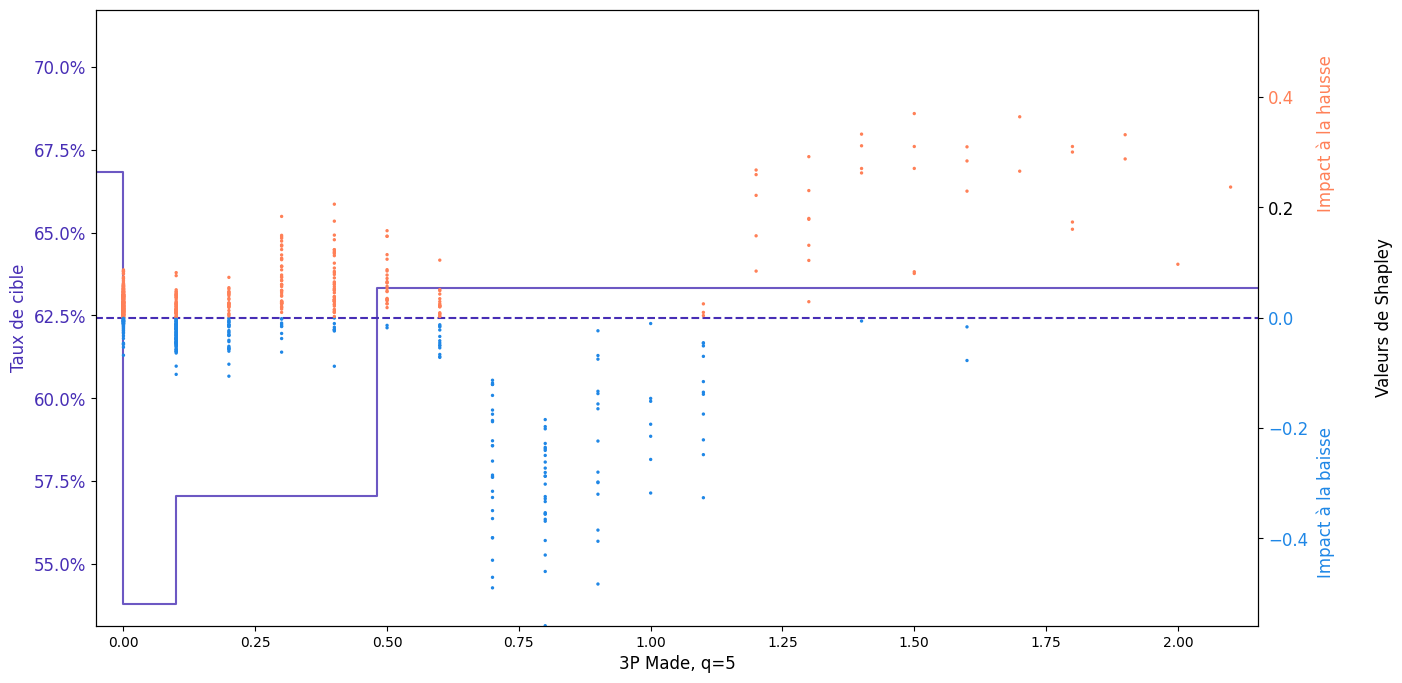

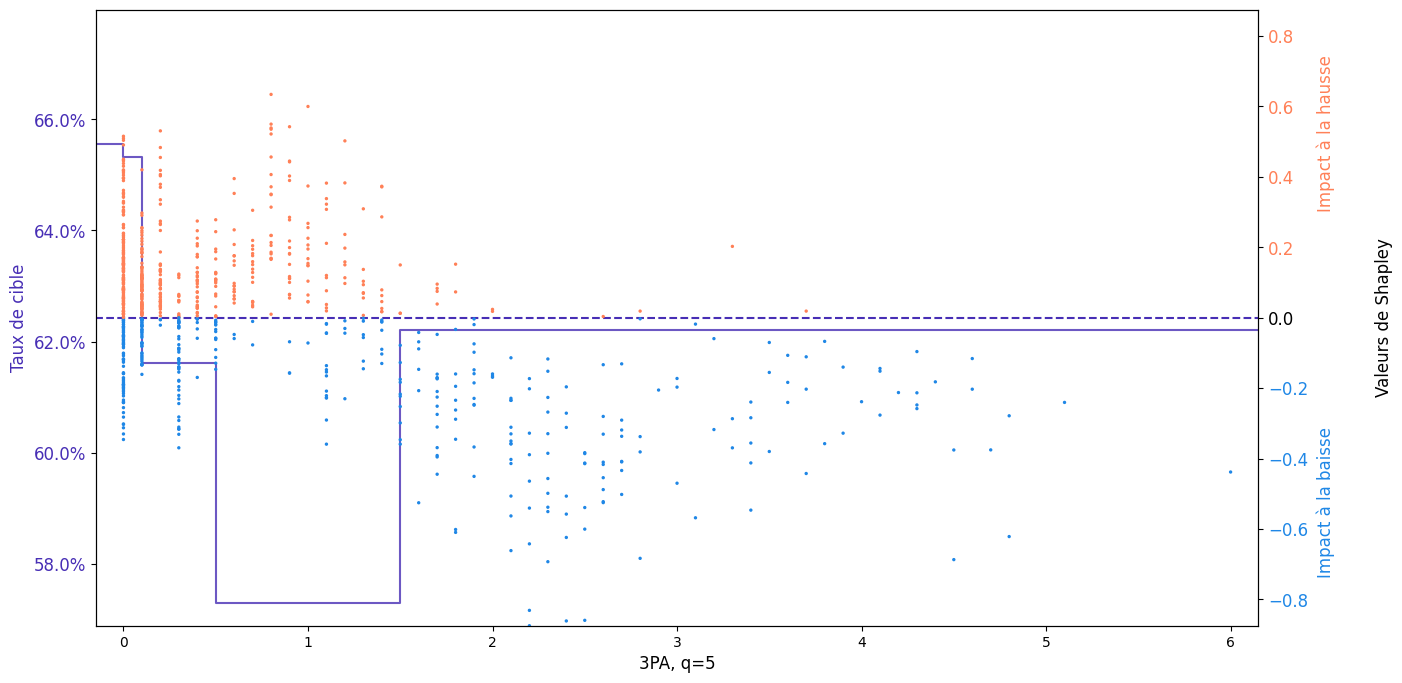

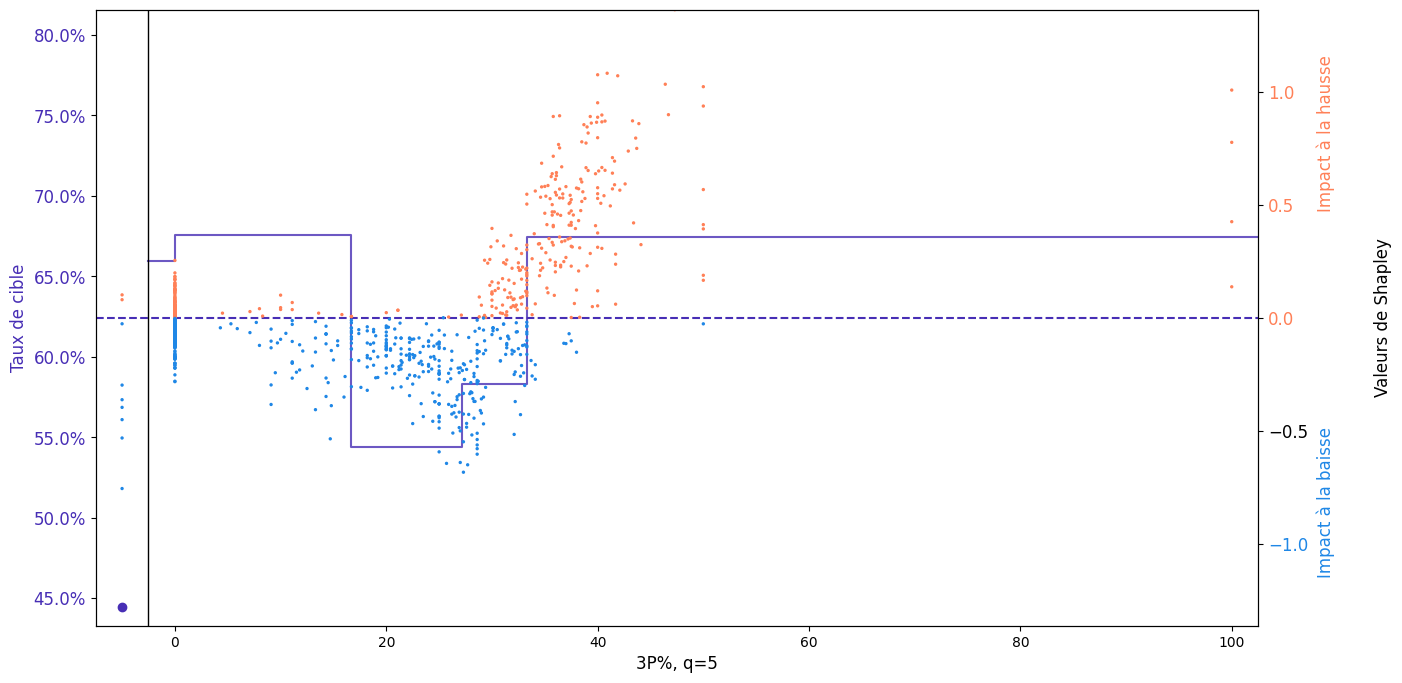

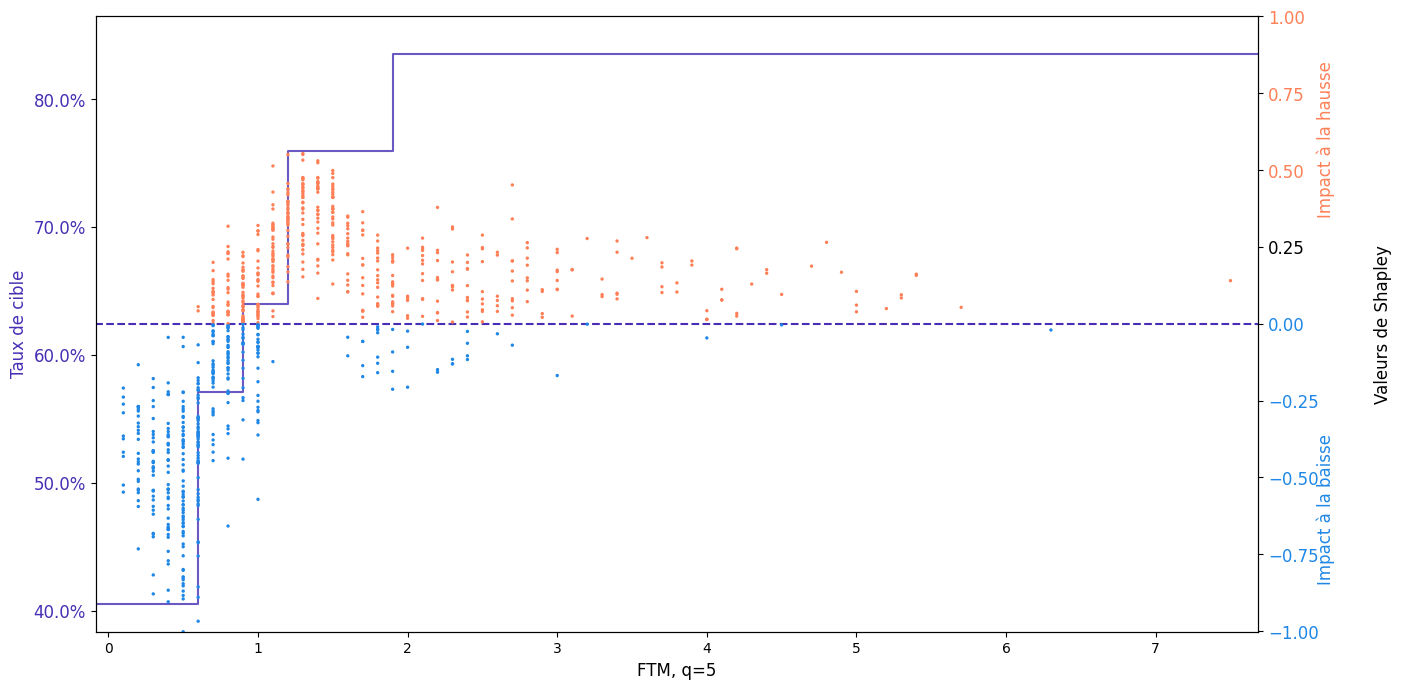

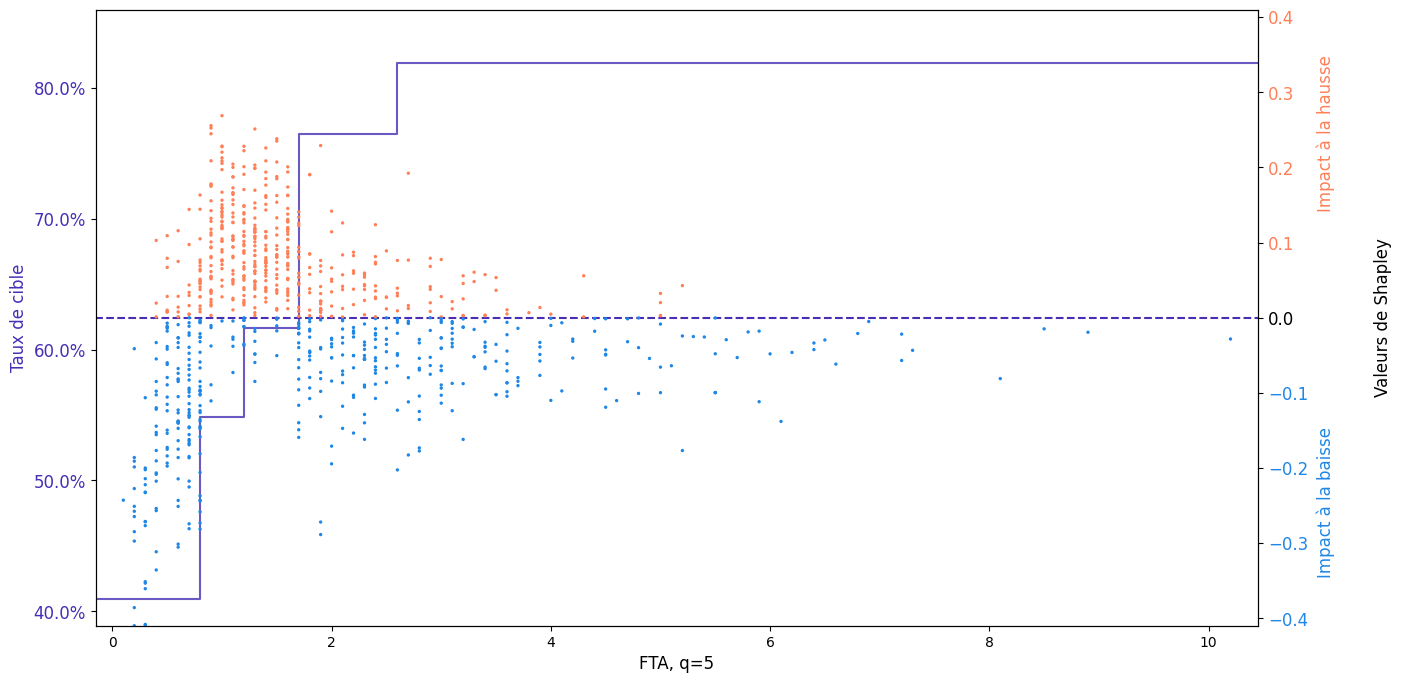

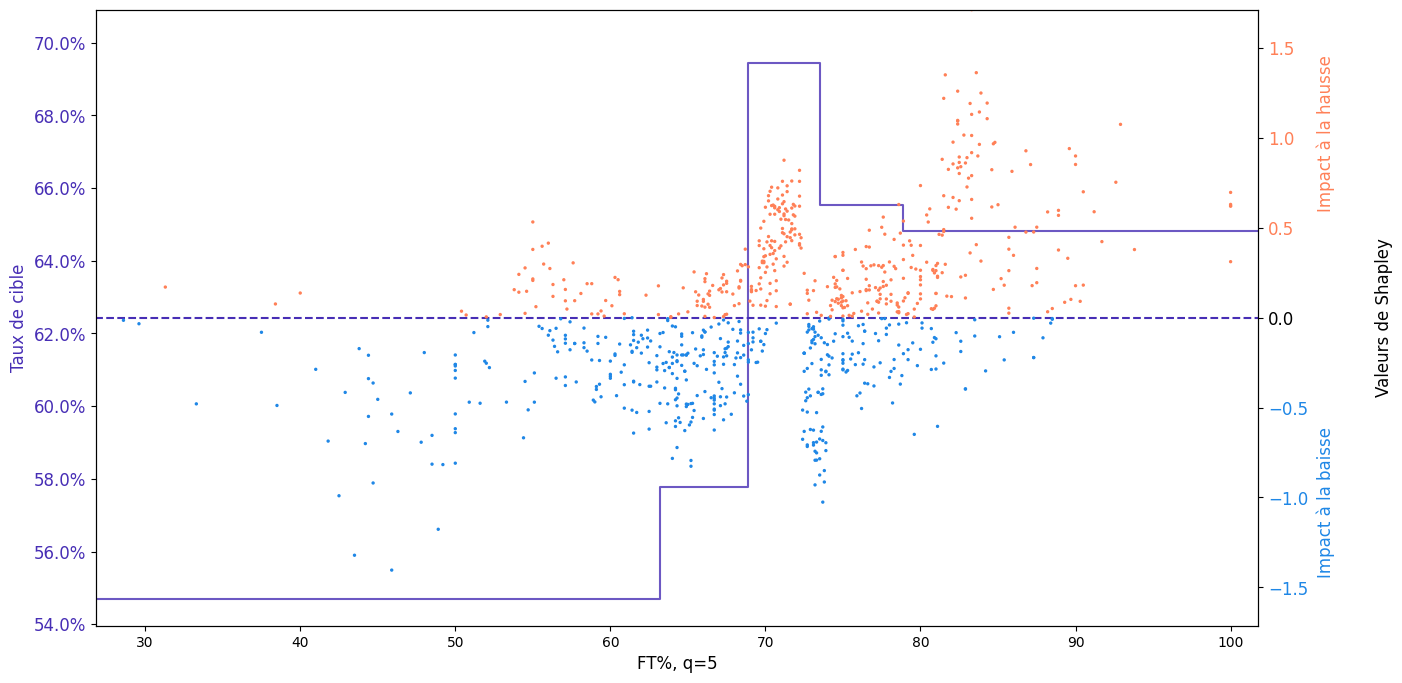

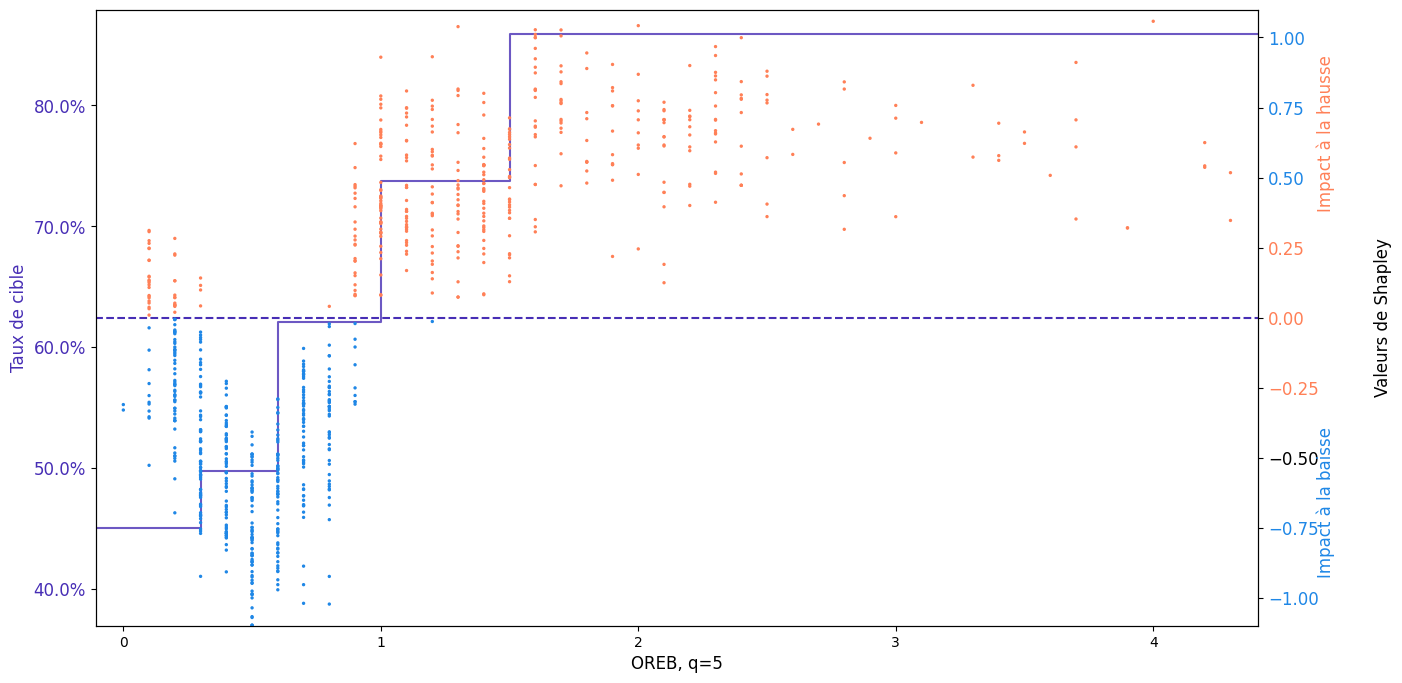

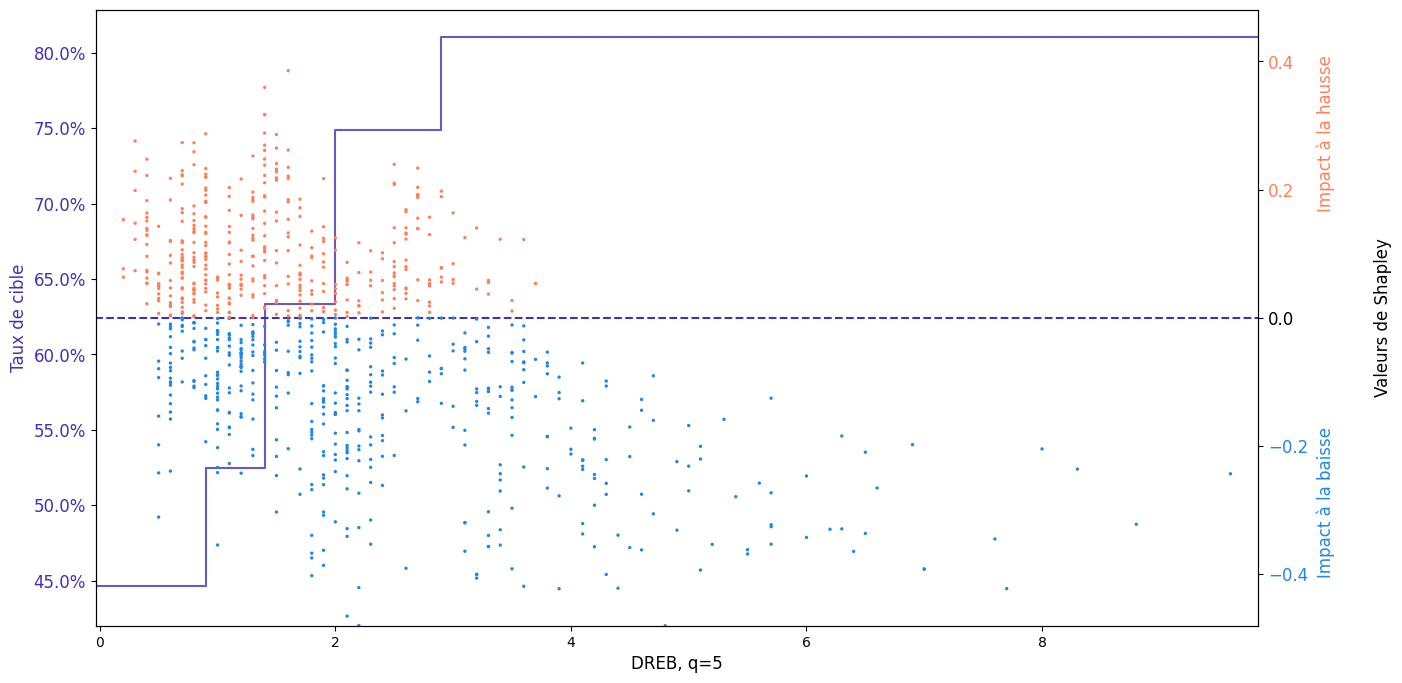

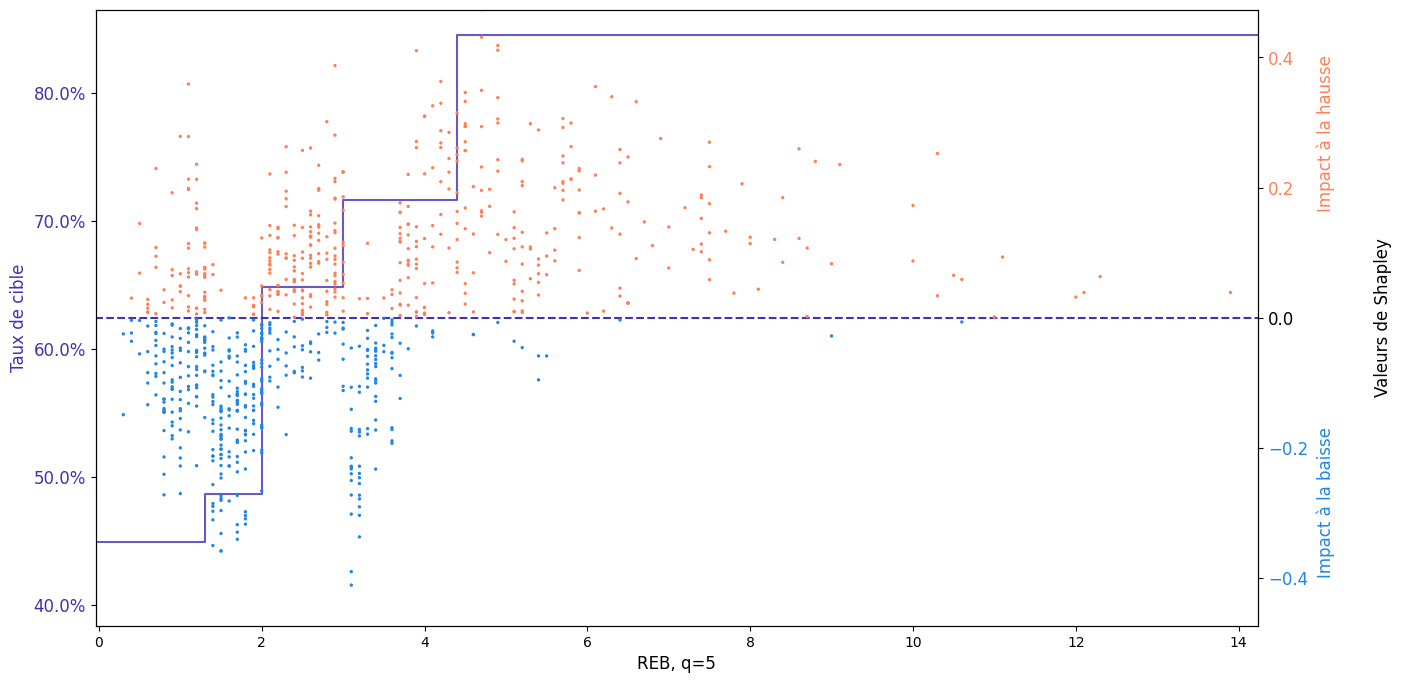

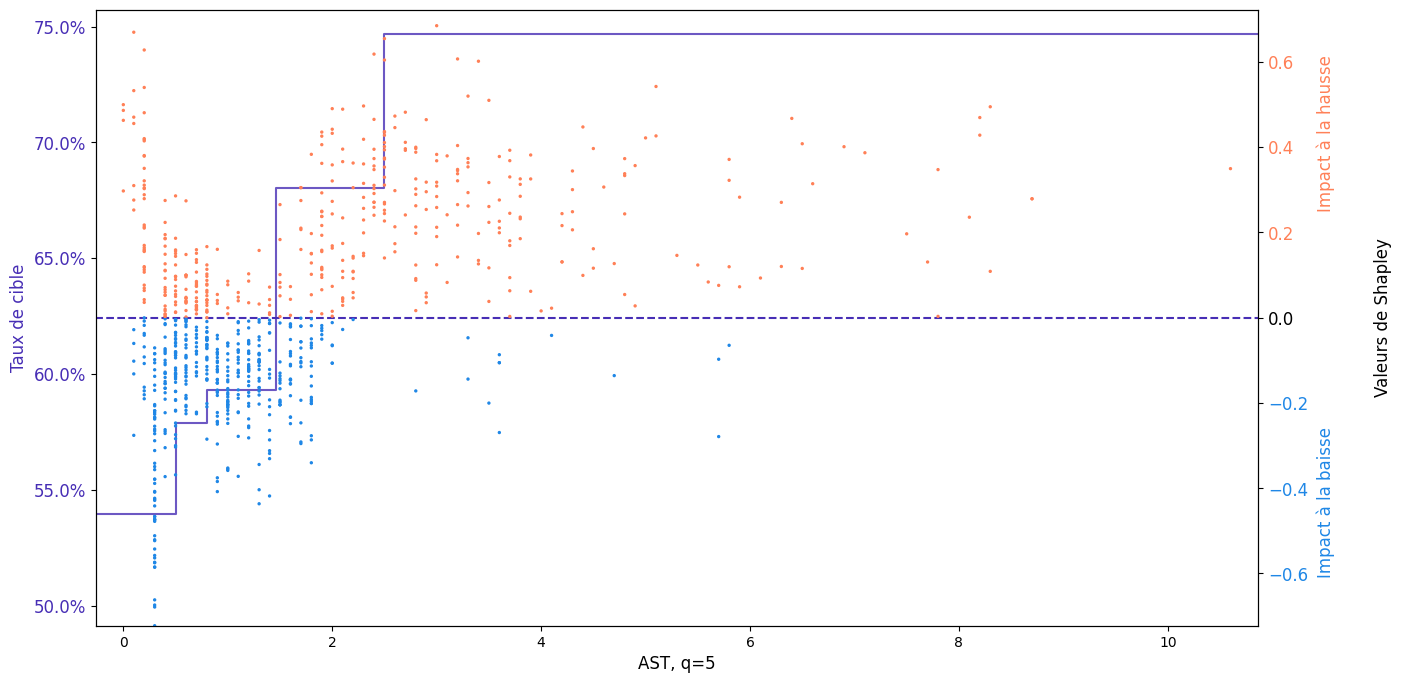

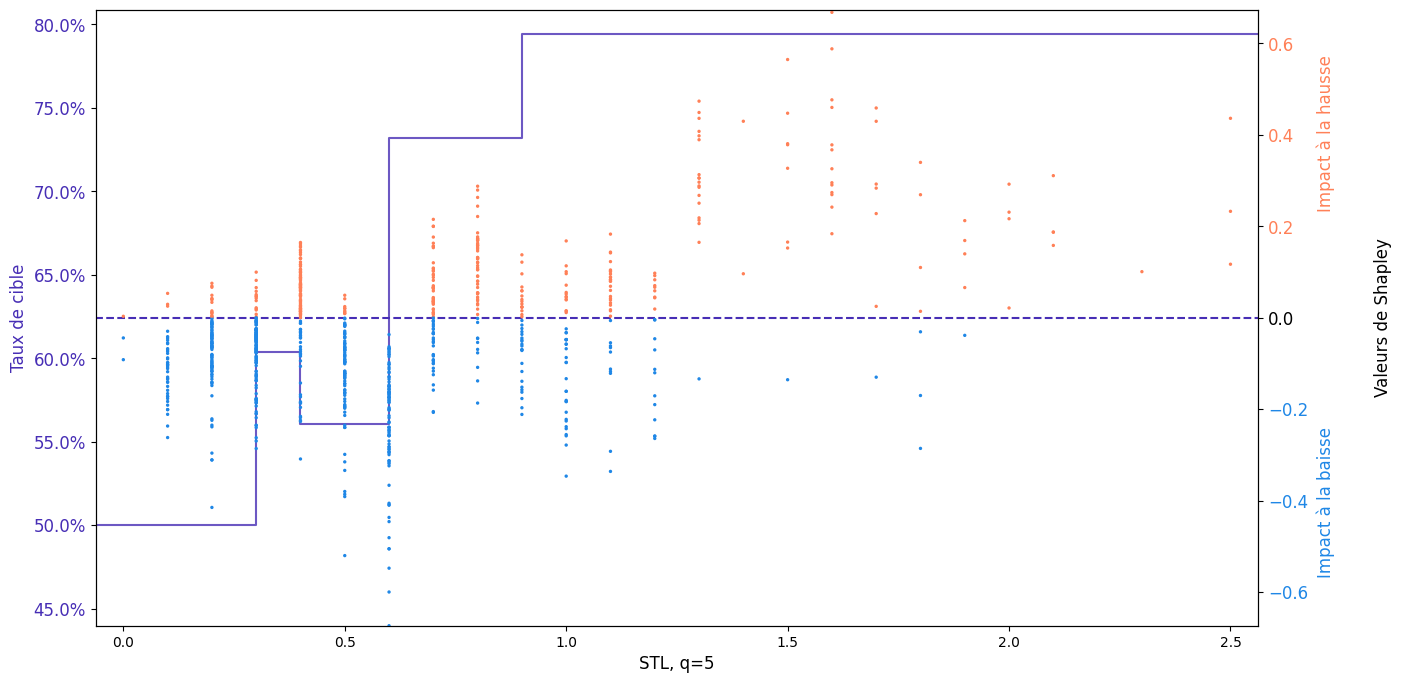

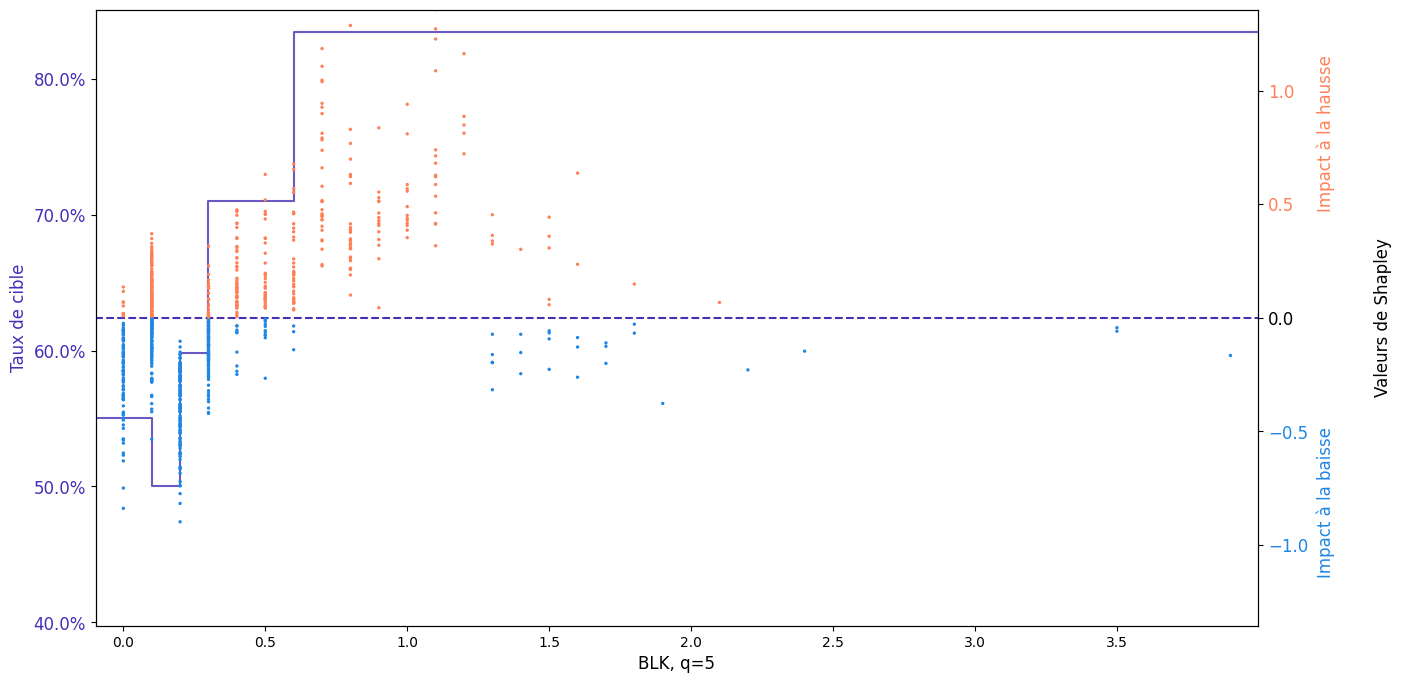

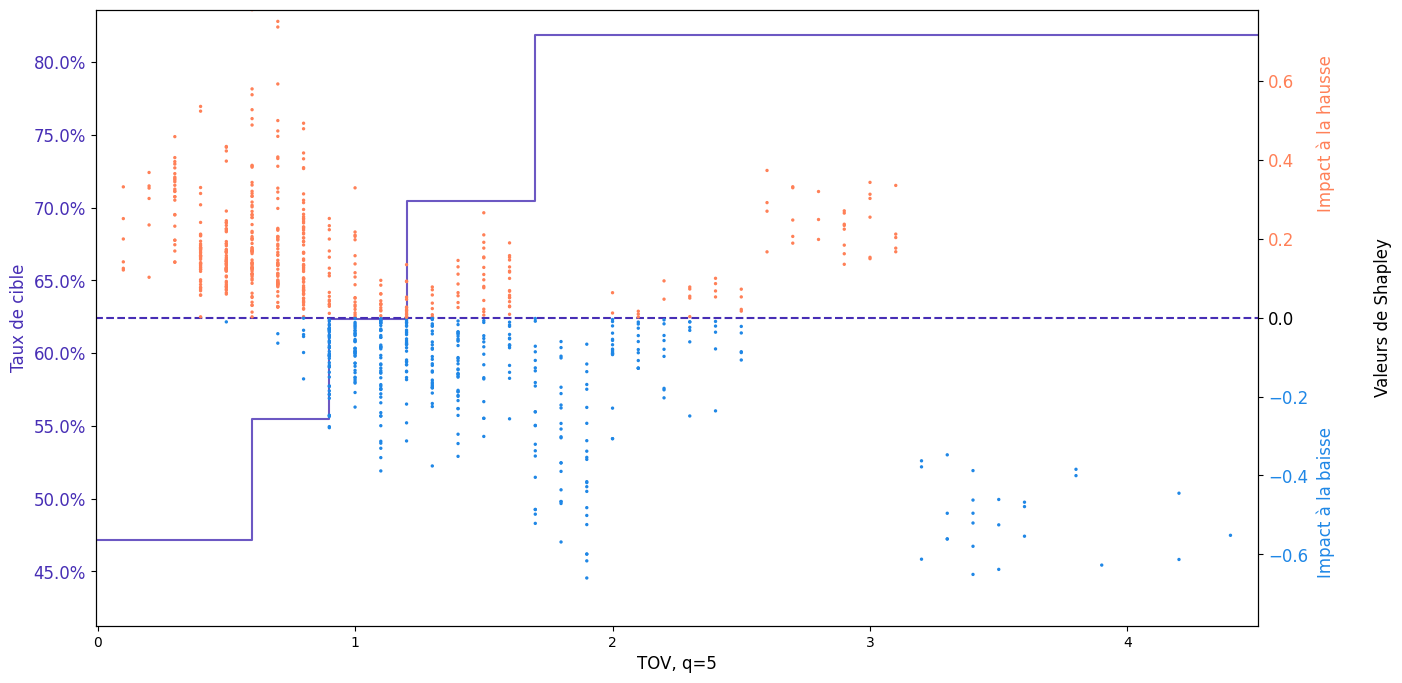

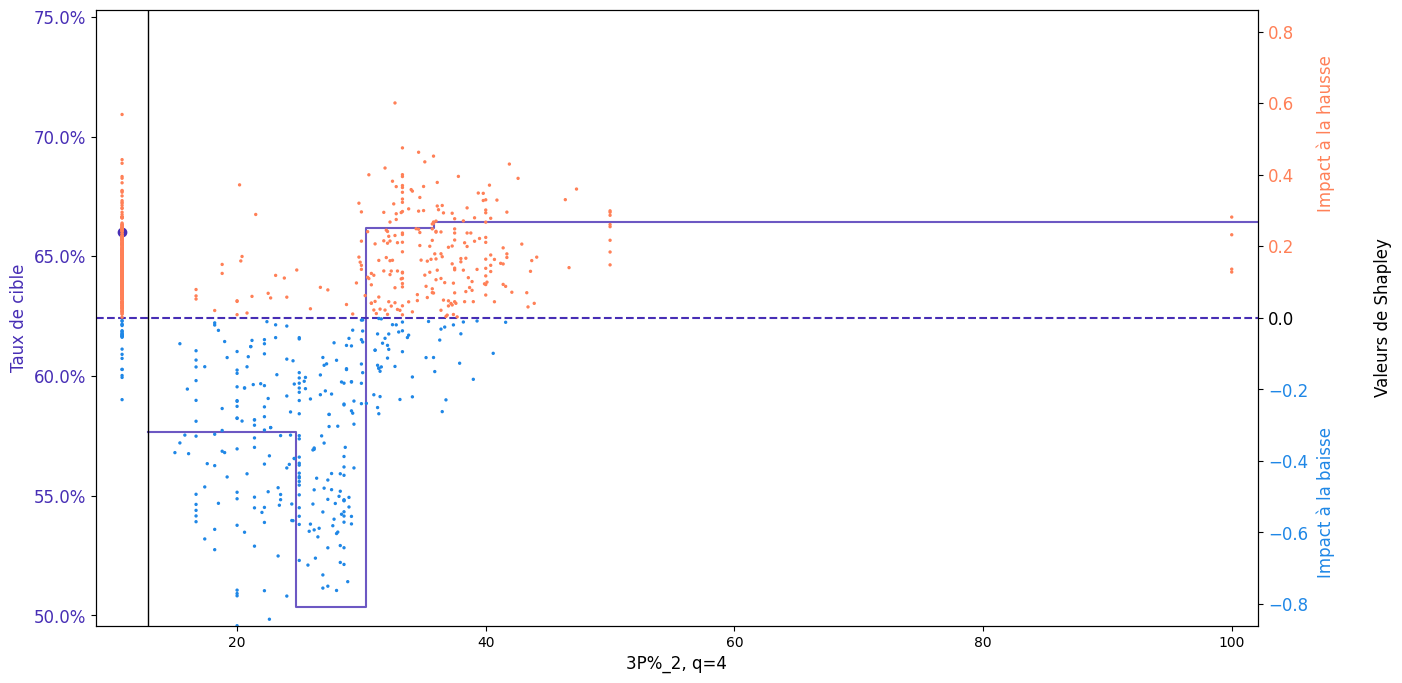

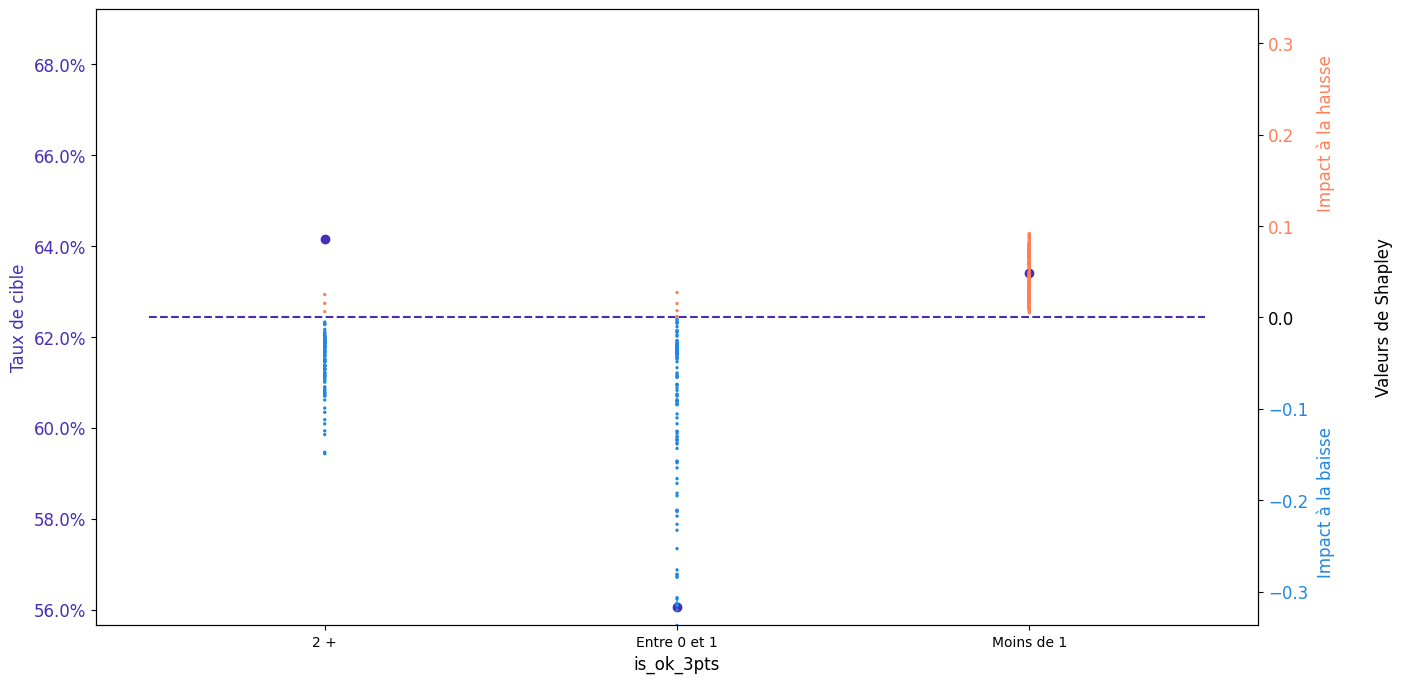

In [11]:
binary_explainer.explain(q=5)

In [12]:
binary_explainer.correctness_features(q=5)

/Users/zachariebuisson/Documents/GitHub/mlexplainer/mlexplainer/explainers/shap/binary.py:198: RuntimeWarning: Mean of empty slice.
  group_shap_mean = feature_shap_values[group_mask].mean()
/Users/zachariebuisson/Documents/GitHub/mlexplainer/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/zachariebuisson/Documents/GitHub/mlexplainer/mlexplainer/explainers/shap/binary.py:198: RuntimeWarning: Mean of empty slice.
  group_shap_mean = feature_shap_values[group_mask].mean()
/Users/zachariebuisson/Documents/GitHub/mlexplainer/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/zachariebuisson/Documents/GitHub/mlexplainer/mlexplainer/explainers/shap/binary.py:198: RuntimeWarning: Mean of empty slice.
  group_shap_mean = feature_shap_values[group_mask].mean()
/Us

{'GP': [(11.0, 43.0, True),
  (43.0, 56.0, True),
  (56.0, 68.0, True),
  (68.0, 79.0, True),
  (79.0, 82.0, True)],
 'MIN': [(4.1, 10.1, False),
  (10.1, 13.7, True),
  (13.7, 18.3, True),
  (18.3, 24.96, False),
  (24.96, 40.1, True)],
 'PTS': [(1.0, 3.3, True),
  (3.3, 4.64, False),
  (4.64, 6.4, True),
  (6.4, 9.88, True),
  (9.88, 24.3, True)],
 'FGM': [(0.4, 1.3, True),
  (1.3, 1.8, True),
  (1.8, 2.5, False),
  (2.5, 3.8, True),
  (3.8, 9.8, True)],
 'FGA': [(0.8, 3.0, False),
  (3.0, 4.1, True),
  (4.1, 5.5, False),
  (5.5, 8.4, True),
  (8.4, 19.8, False)],
 'FG%': [(23.8, 38.9, True),
  (38.9, 42.34, False),
  (42.34, 45.5, True),
  (45.5, 48.6, True),
  (48.6, 73.7, False)],
 '3P Made': [(0.0, 0.0, True),
  (0.0, 0.1, True),
  (0.1, 0.48, True),
  (0.4, 2.1, False)],
 '3PA': [(0.0, 0.0, True),
  (0.0, 0.1, True),
  (0.1, 0.5, False),
  (0.5, 1.5, False),
  (1.5, 6.0, True)],
 '3P%': [(nan, nan, True),
  (0.0, 0.0, False),
  (0.0, 16.7, False),
  (8.0, 27.12, True),
  (22.5, 

### Mutli Label Class dependencies

In [13]:
# 
dataframe['random_column'] = np.random.choice([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], size=dataframe.shape[0])
dataframe['random_feature'] = np.random.choice([0, 1, 2, 3, 4], size=dataframe.shape[0])

target = 'random_feature'
selected_features = [c for c in dataframe if (c != target) and c not in ["Name"]]

### Séparation en X et y ###
X, y = dataframe, dataframe[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [14]:
model = LGBMClassifier()
fitted_model = model.fit(X_train[selected_features], y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1827
[LightGBM] [Info] Number of data points in the train set: 897, number of used features: 23
[LightGBM] [Info] Start training from score -1.611670
[LightGBM] [Info] Start training from score -1.730152
[LightGBM] [Info] Start training from score -1.515852
[LightGBM] [Info] Start training from score -1.606099
[LightGBM] [Info] Start training from score -1.595049


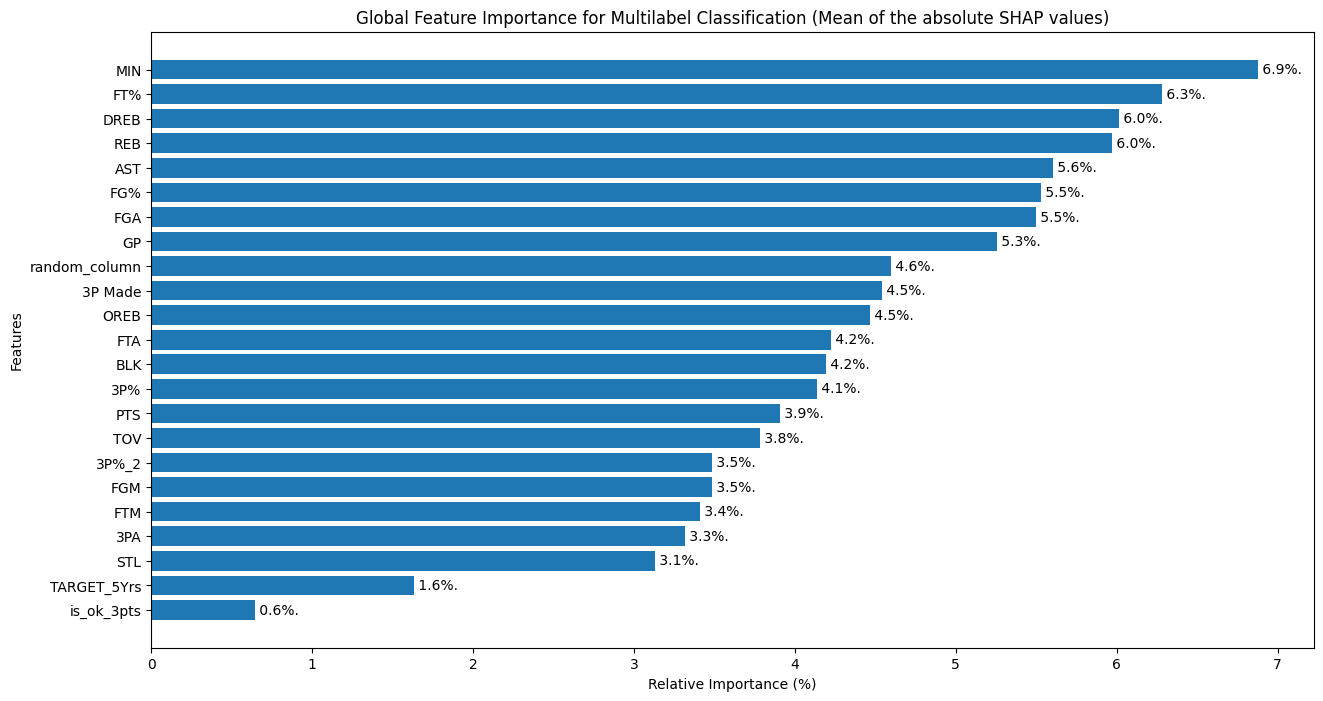

[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, 

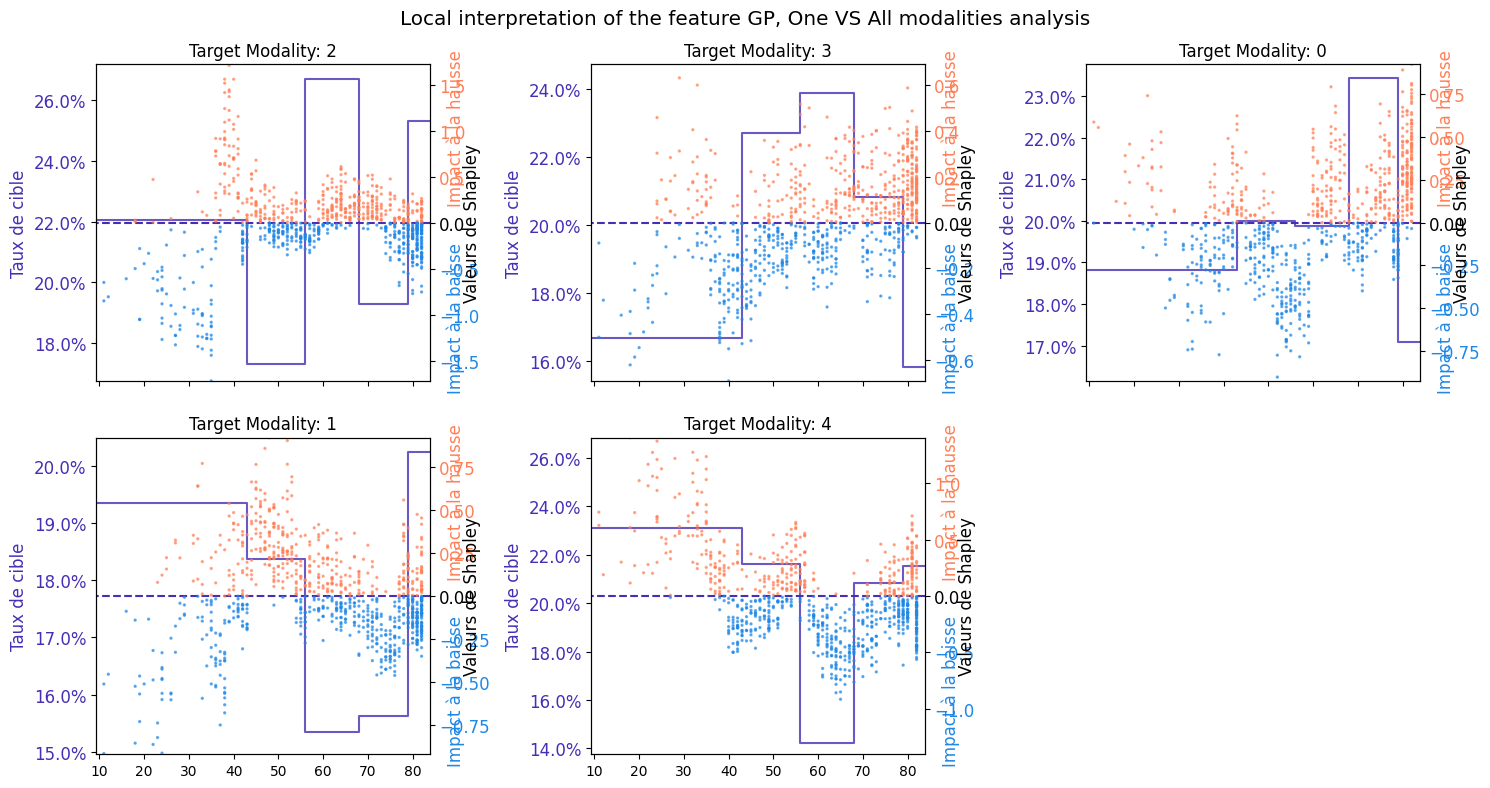

[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -3.0, '−3'), Text(1, -2.0, '−2'), Text(1, -1.0, '−1'), Text(1, 0.0, '0'), Text(1, 1.0, '1'), Text(1, 2.0, '2'), Text(1, 3.0, '3')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -3.0, '−3'), Text(1, -2.0, '−2'), Text(1, -1.0, '−1'), Text(1, 0.0, '0'), Text(1, 1.0, '1'), Text(1, 2.0, '2'), Text(1, 3.0, '3')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]


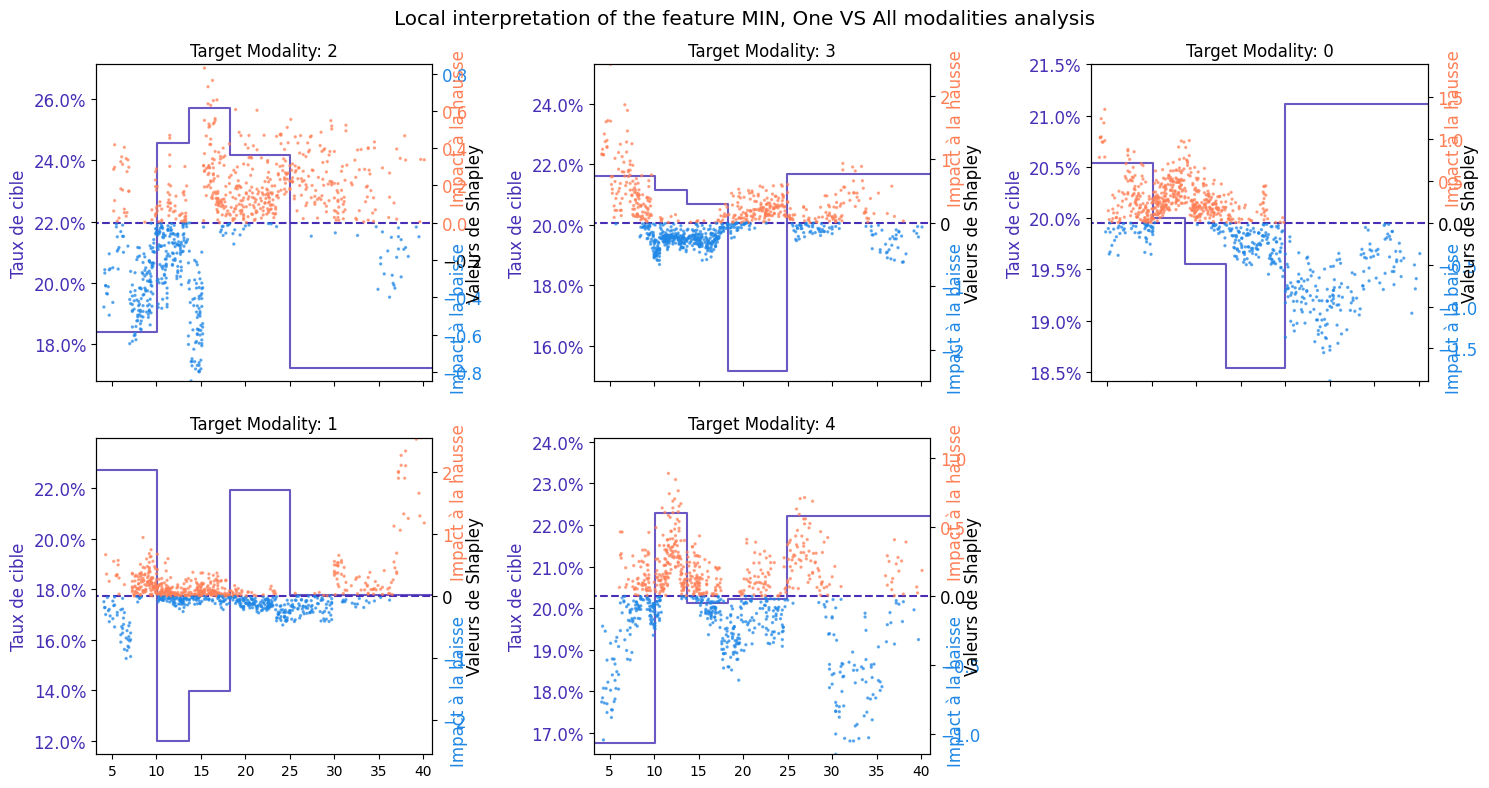

[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.4000000000

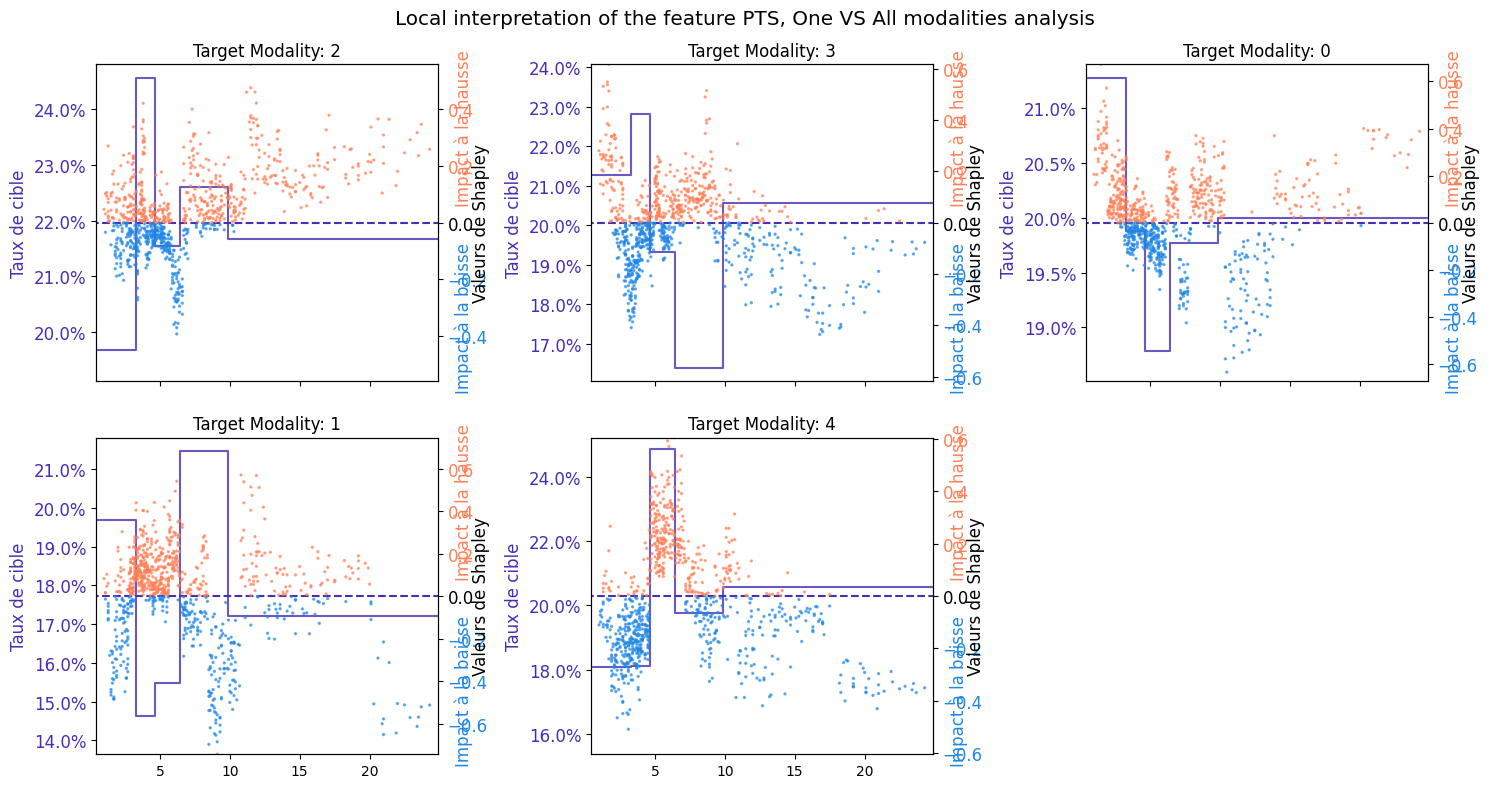

[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'),

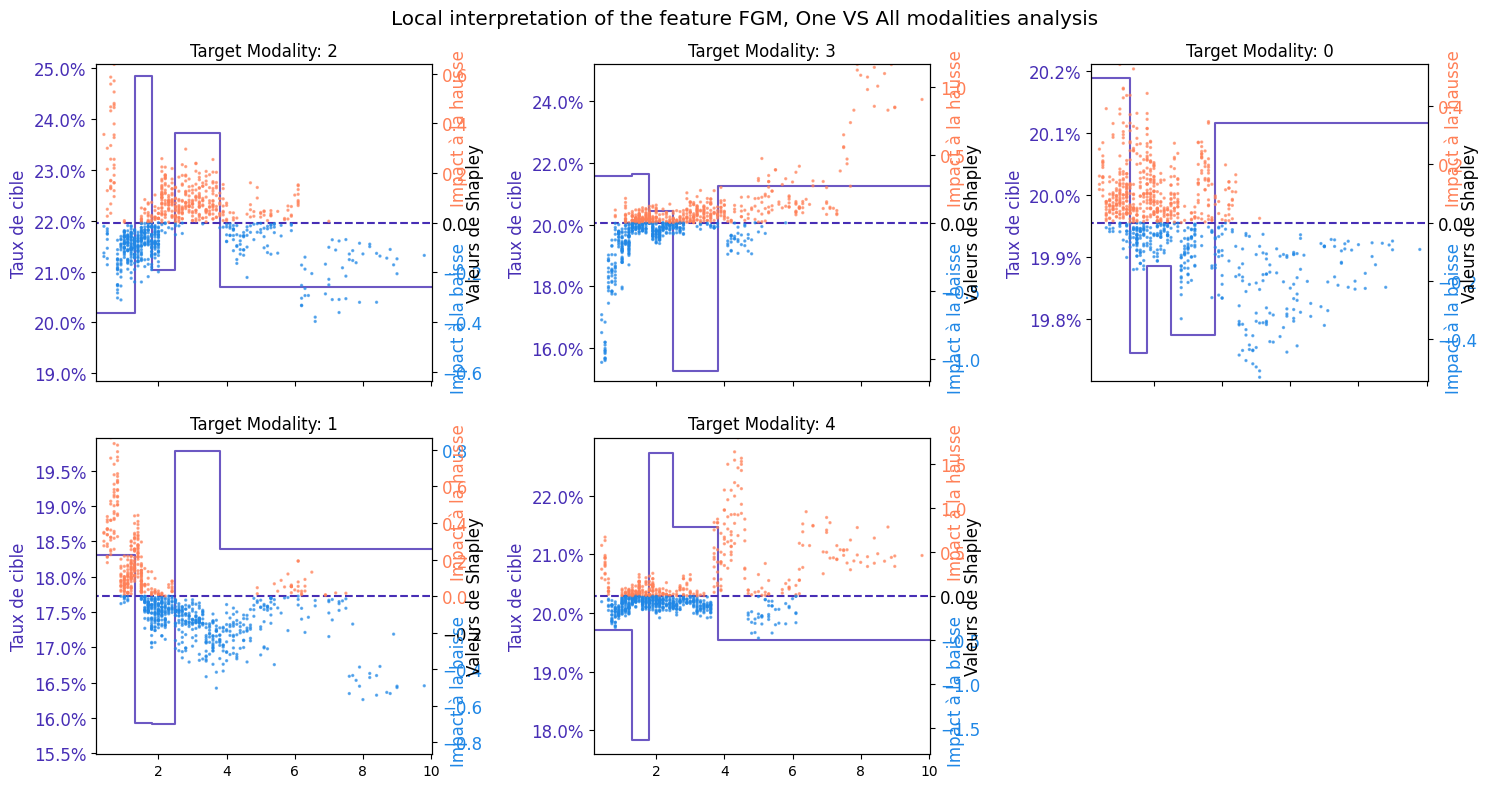

[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.199999

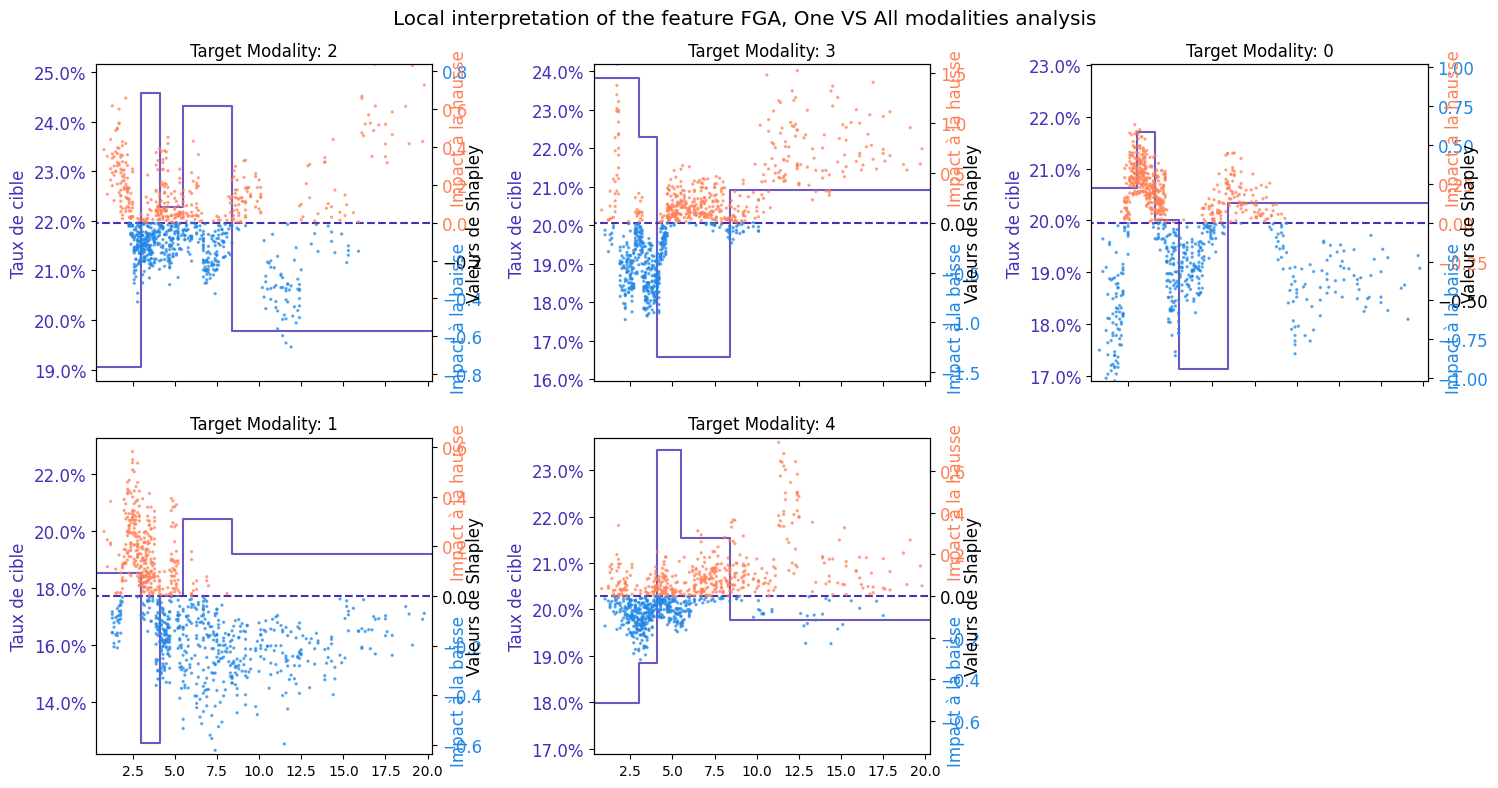

[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]


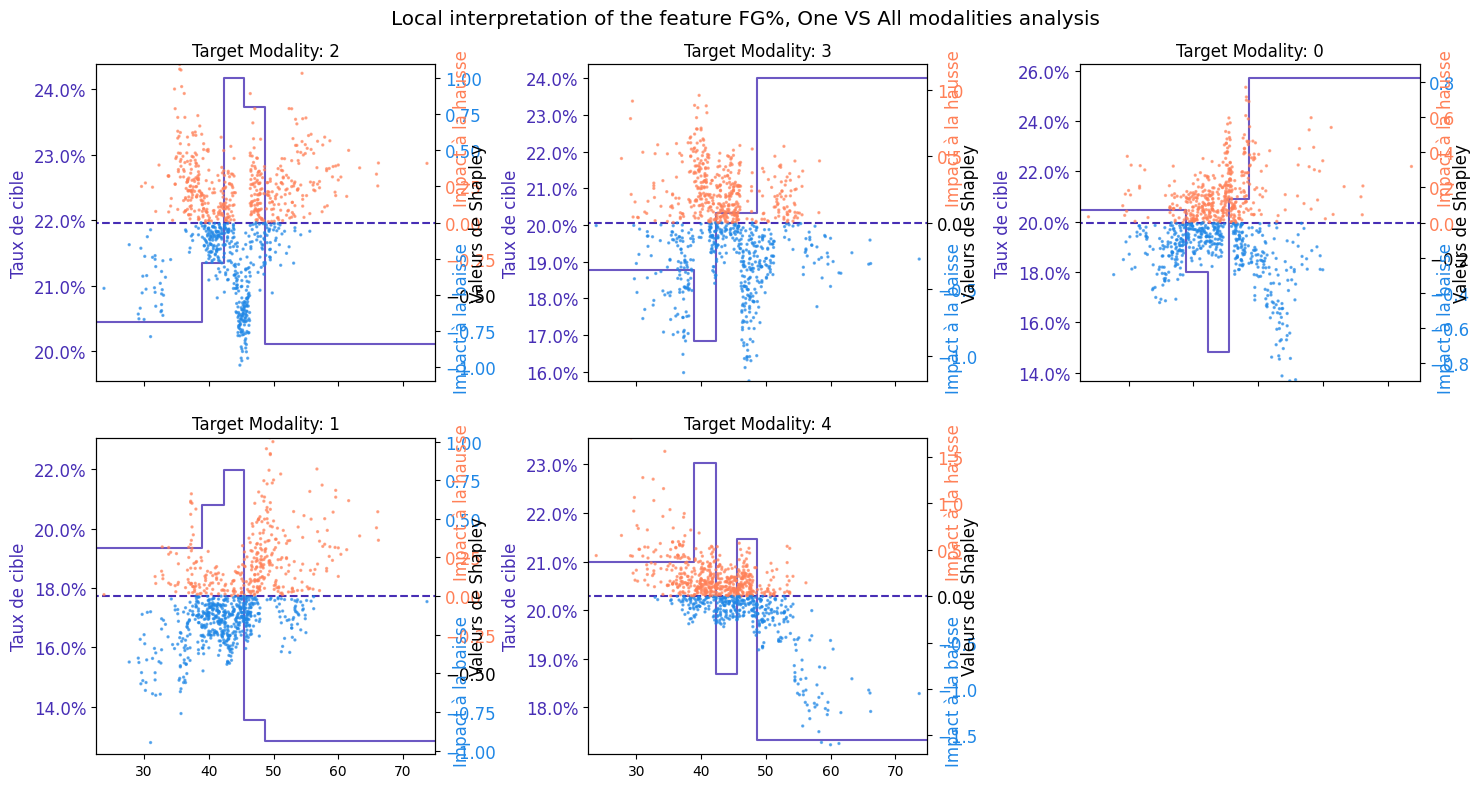

[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.4, '−0.4'), Text(1, -0.30000000000000004, '−0.3'), Text(1, -0.2, '−0.2'), Text(1, -0.09999999999999998, '−0.1'), Text(1, 0.0, '0.0'), Text(1, 0.09999999999999998, '0.1'), Text(1, 0.20000000000000007, '0.2'), Text(1, 0.30000000000000004, '0.3'), Text(1, 0.4, '0.4')]
[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999

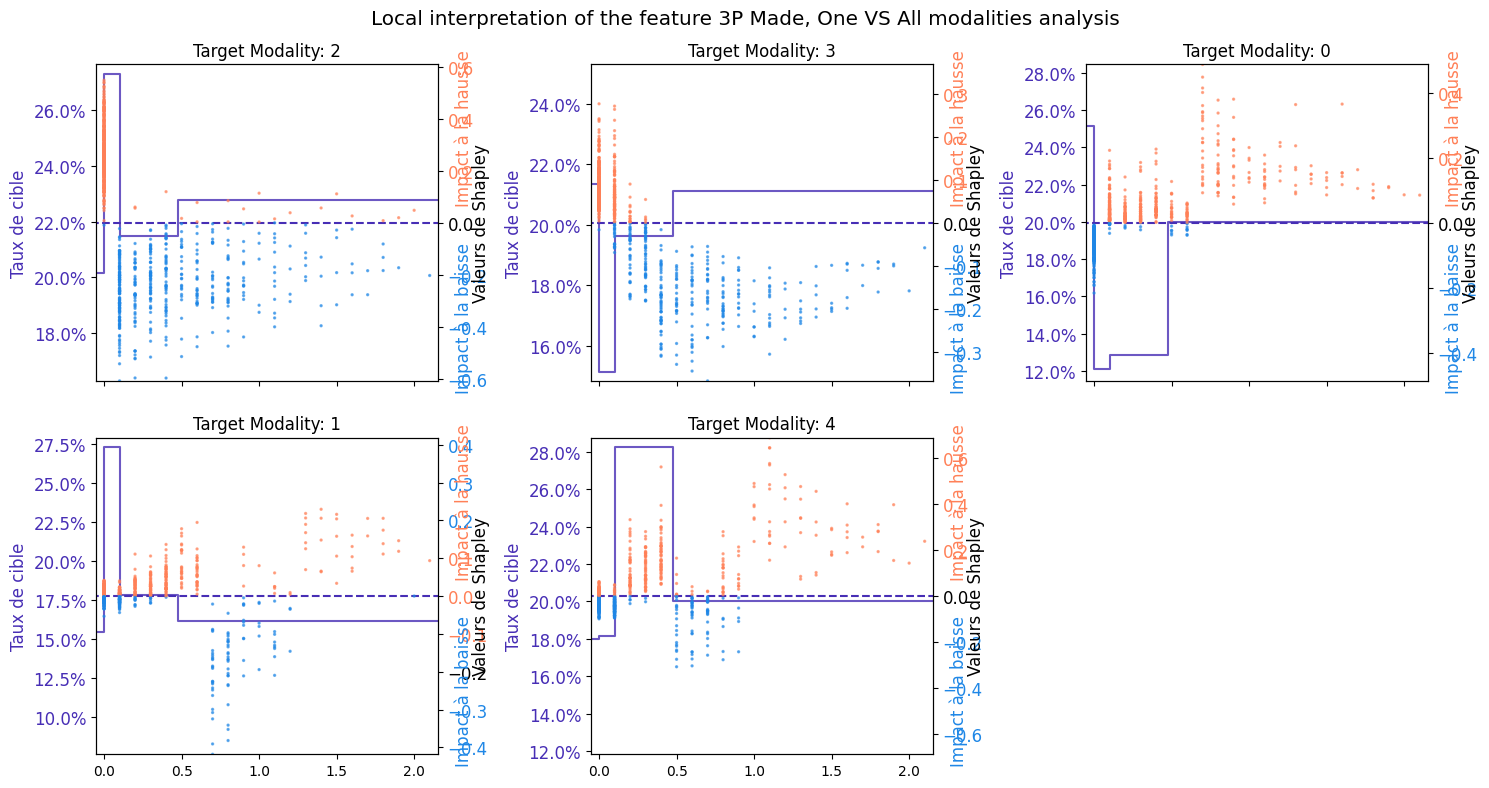

[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'),

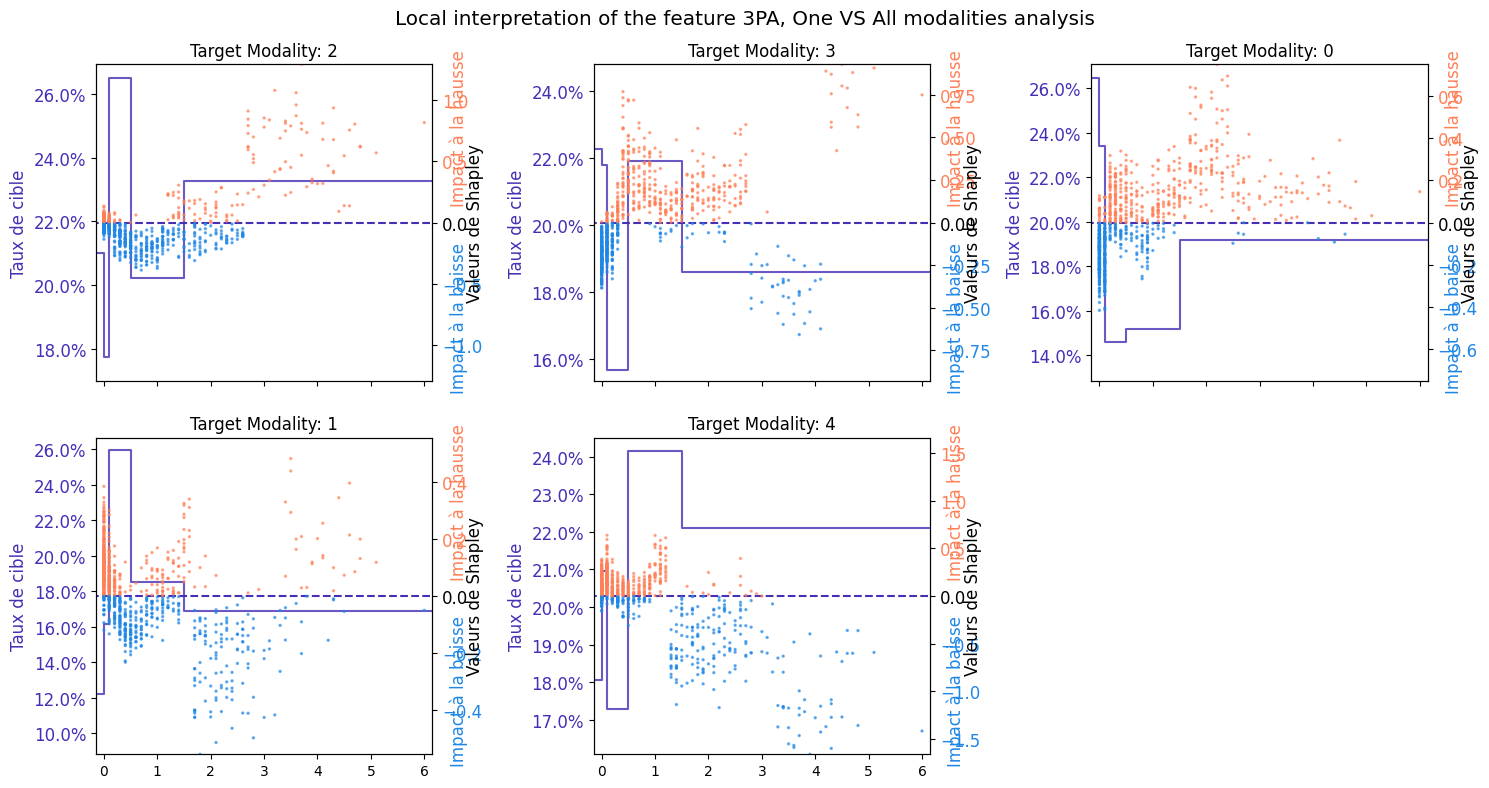

[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -3.0, '−3'), Text(1, -2.0, '−2'), Text(1, -1.0, '−1'), Text(1, 0.0, '0'), Text(1, 1.0, '1'), Text(1, 2.0, '2'), Text(1, 3.0, '3')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]


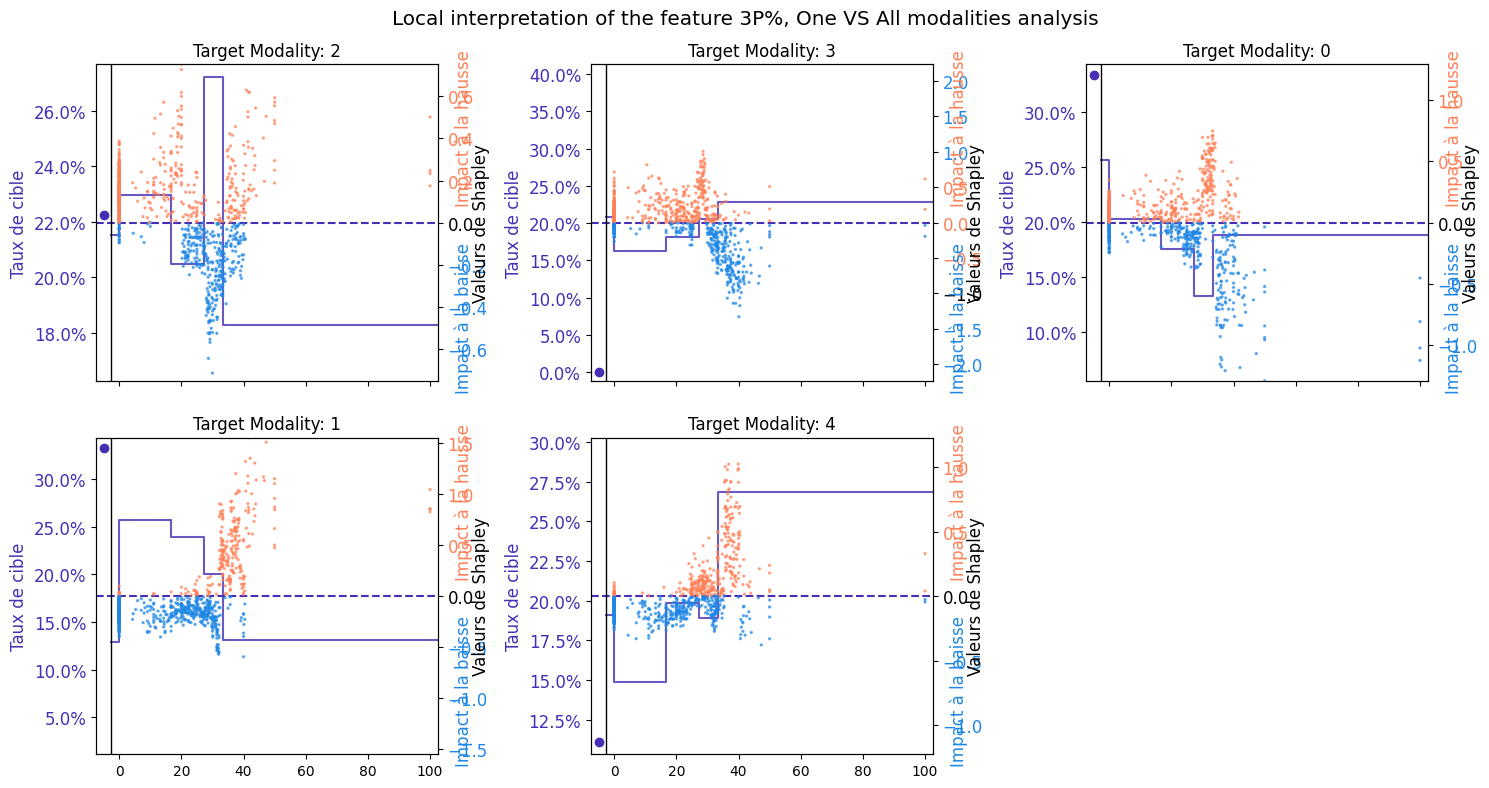

[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.199999

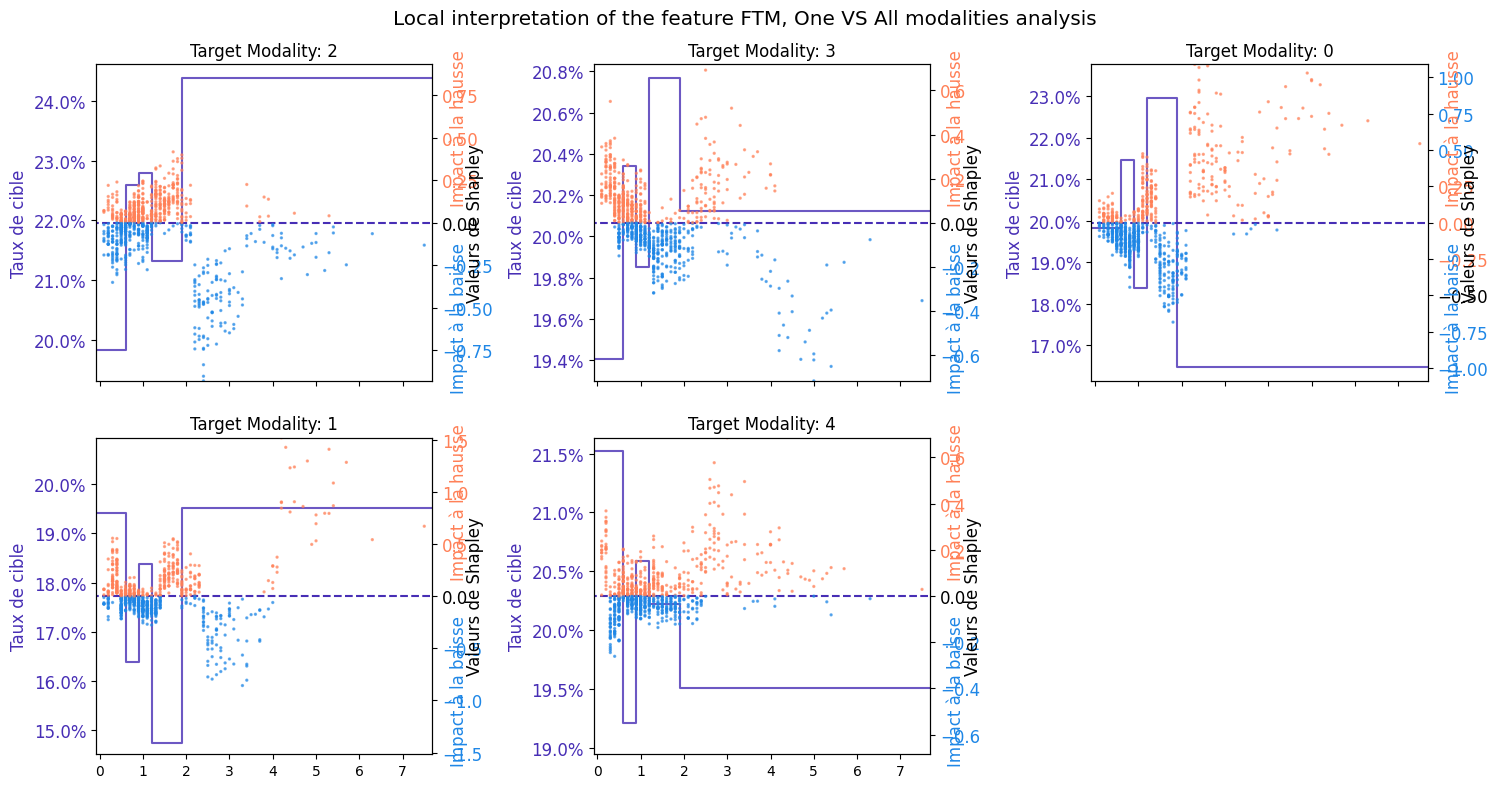

[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]


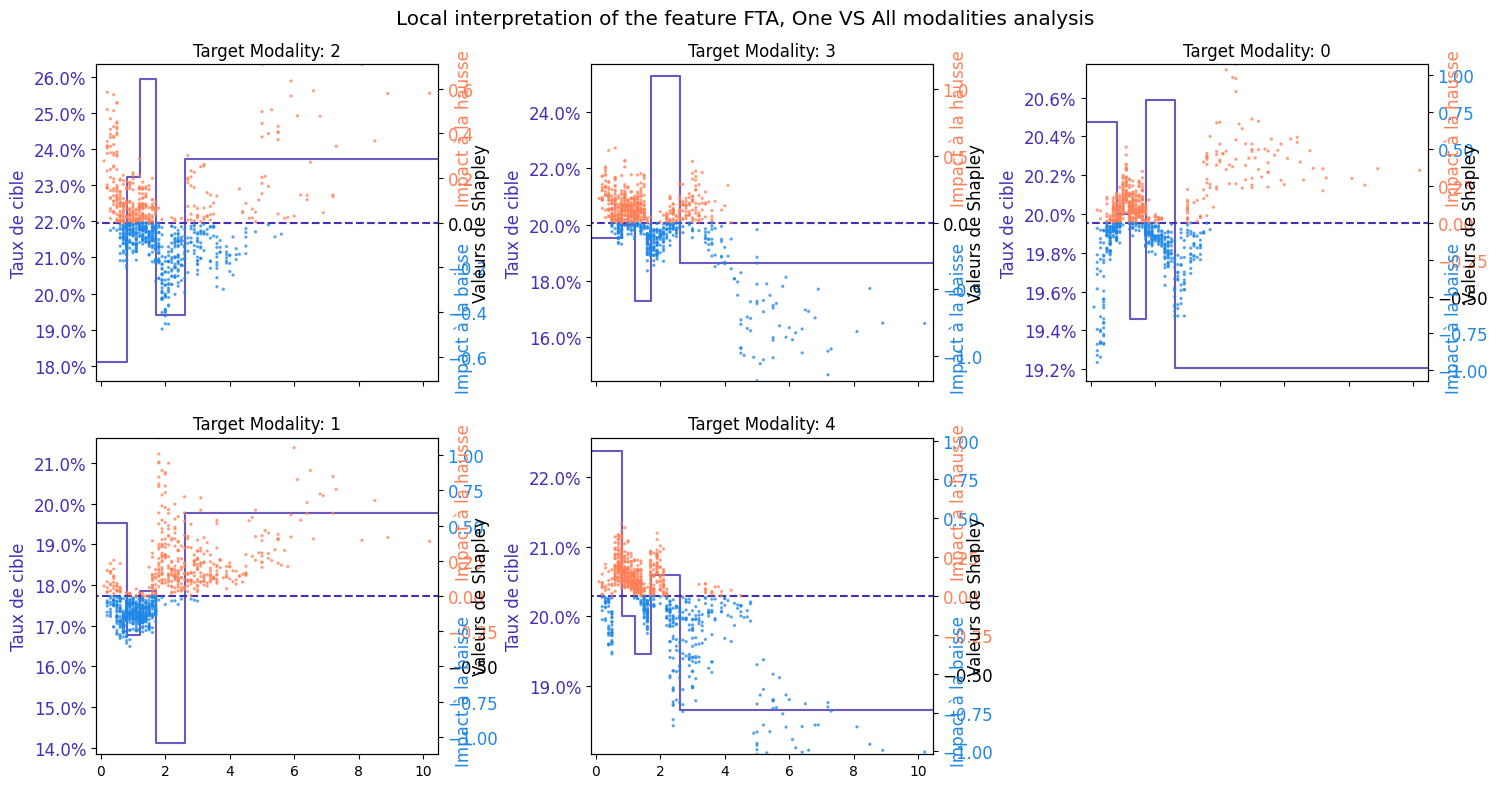

[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]


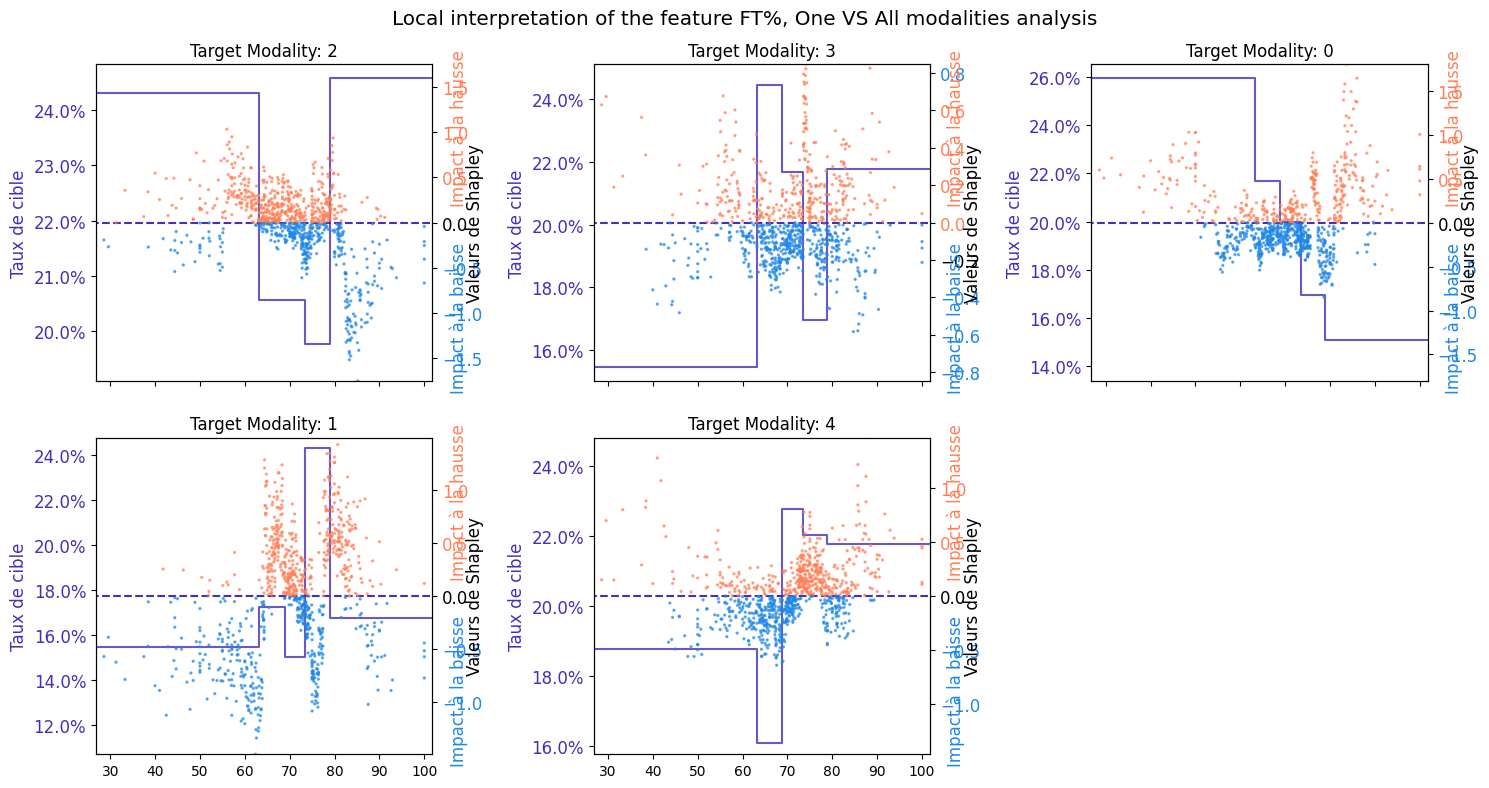

[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text

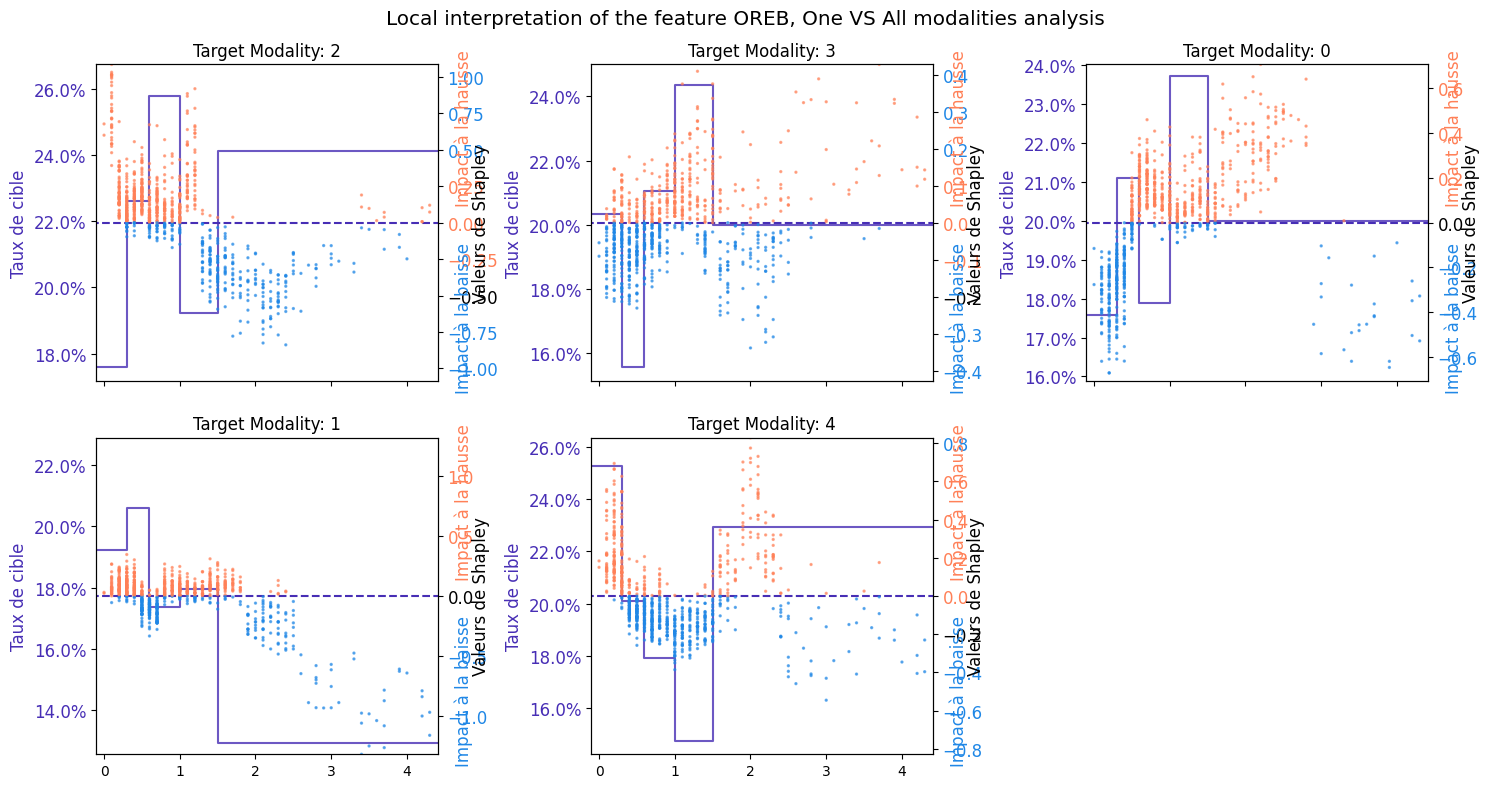

[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.6000000000000001, '−0.6'), 

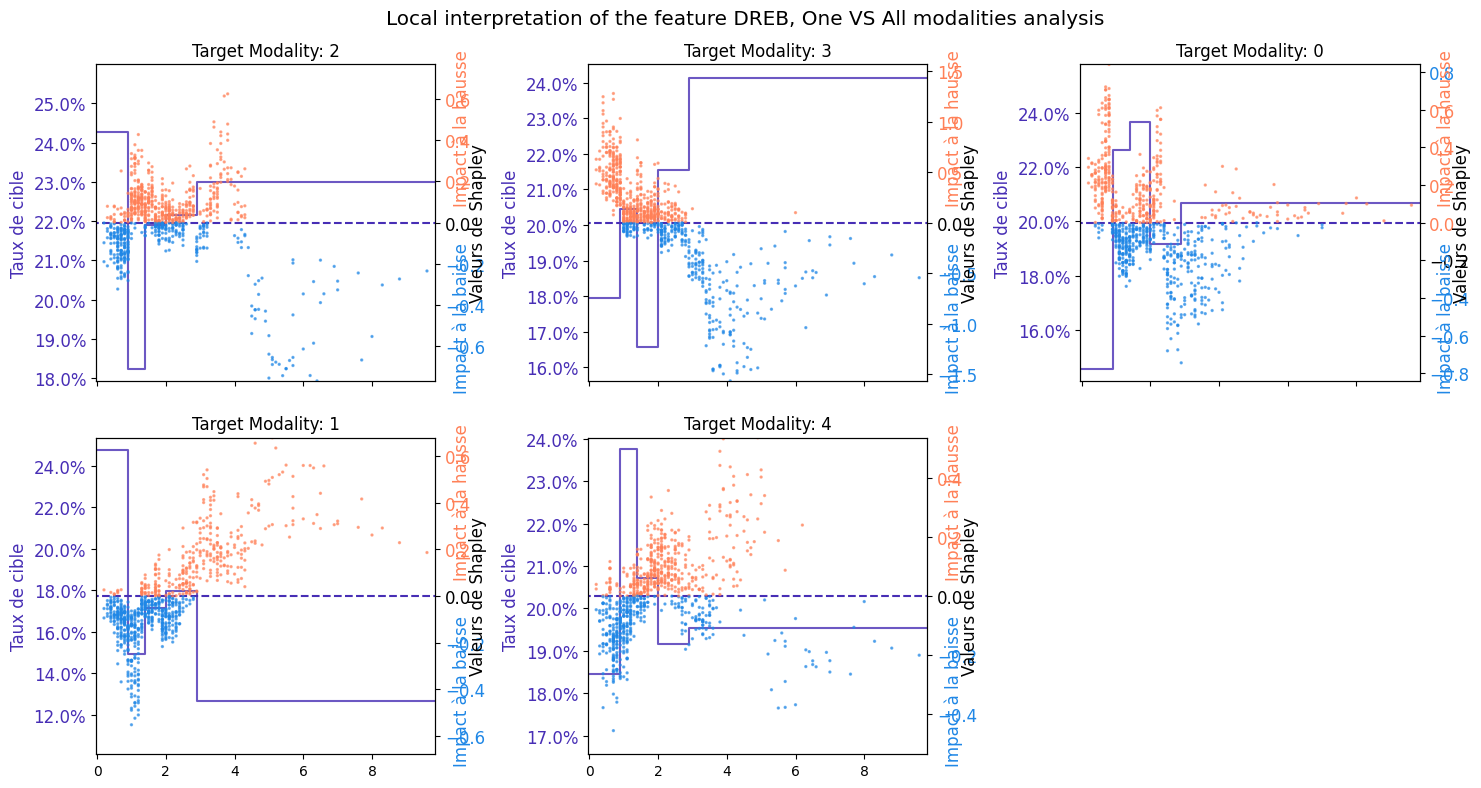

[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]


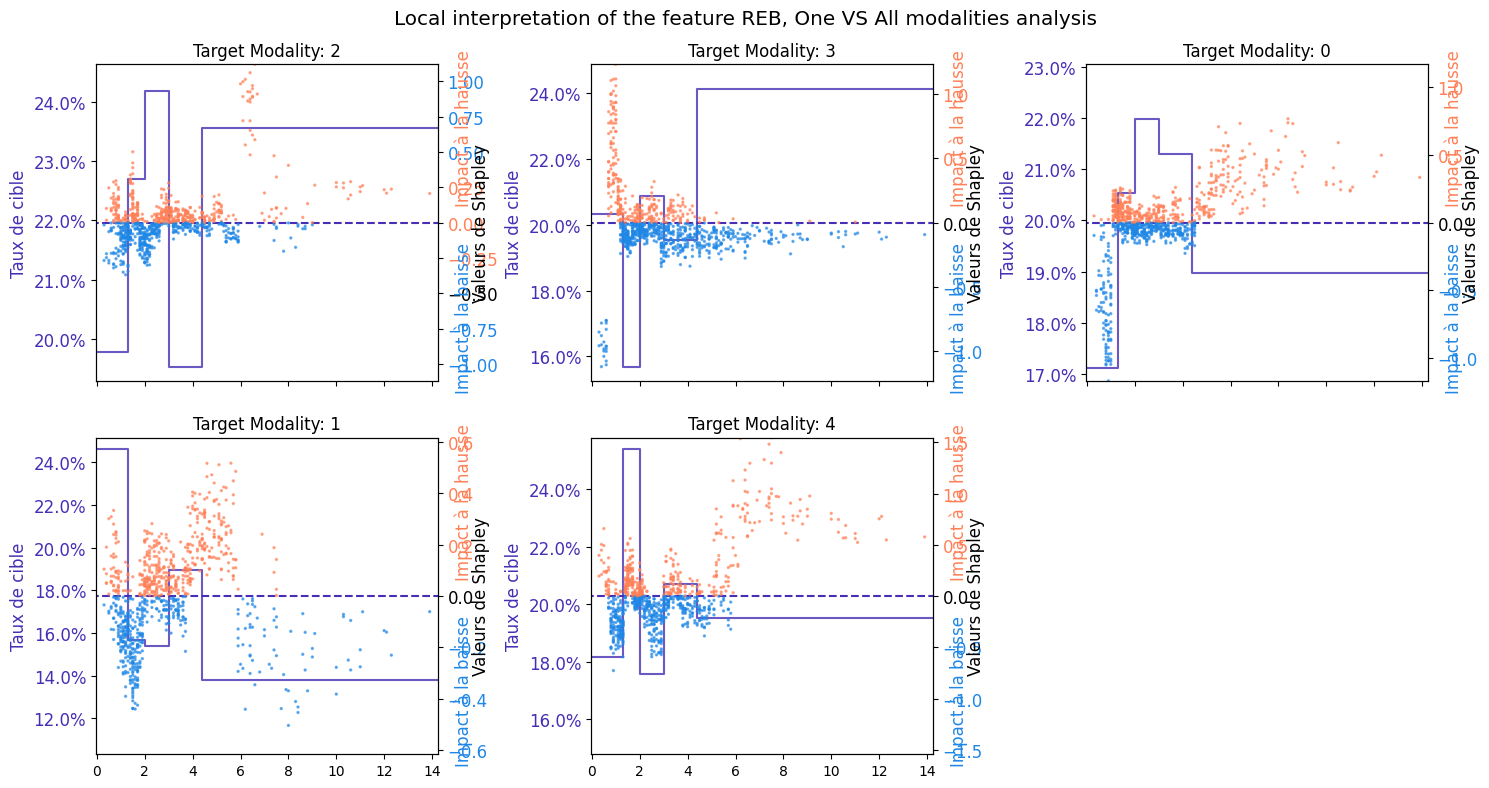

[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]


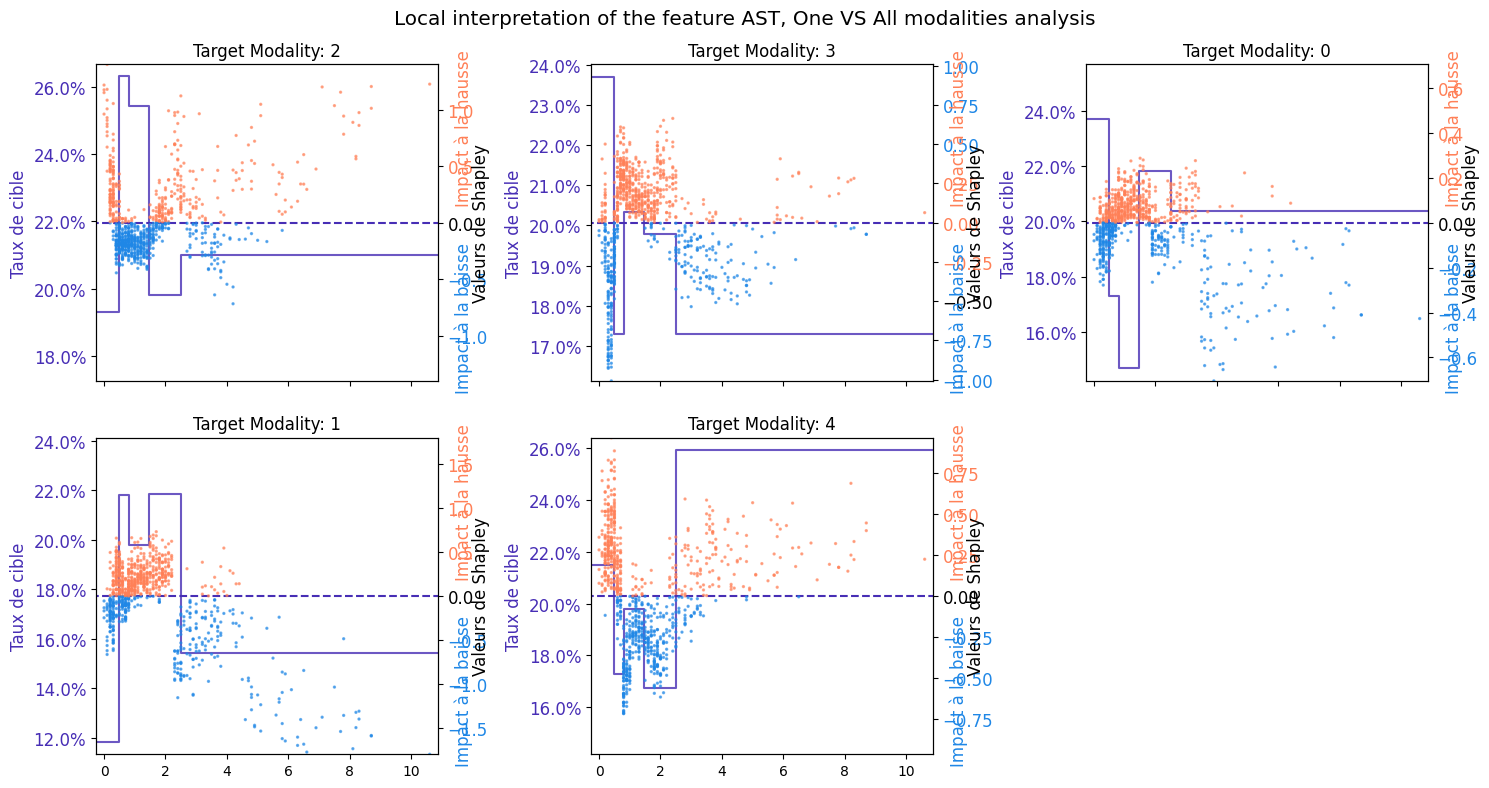

[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -2.0, '−2.0'), Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5'), Text(1, 2.0, '2.0')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.

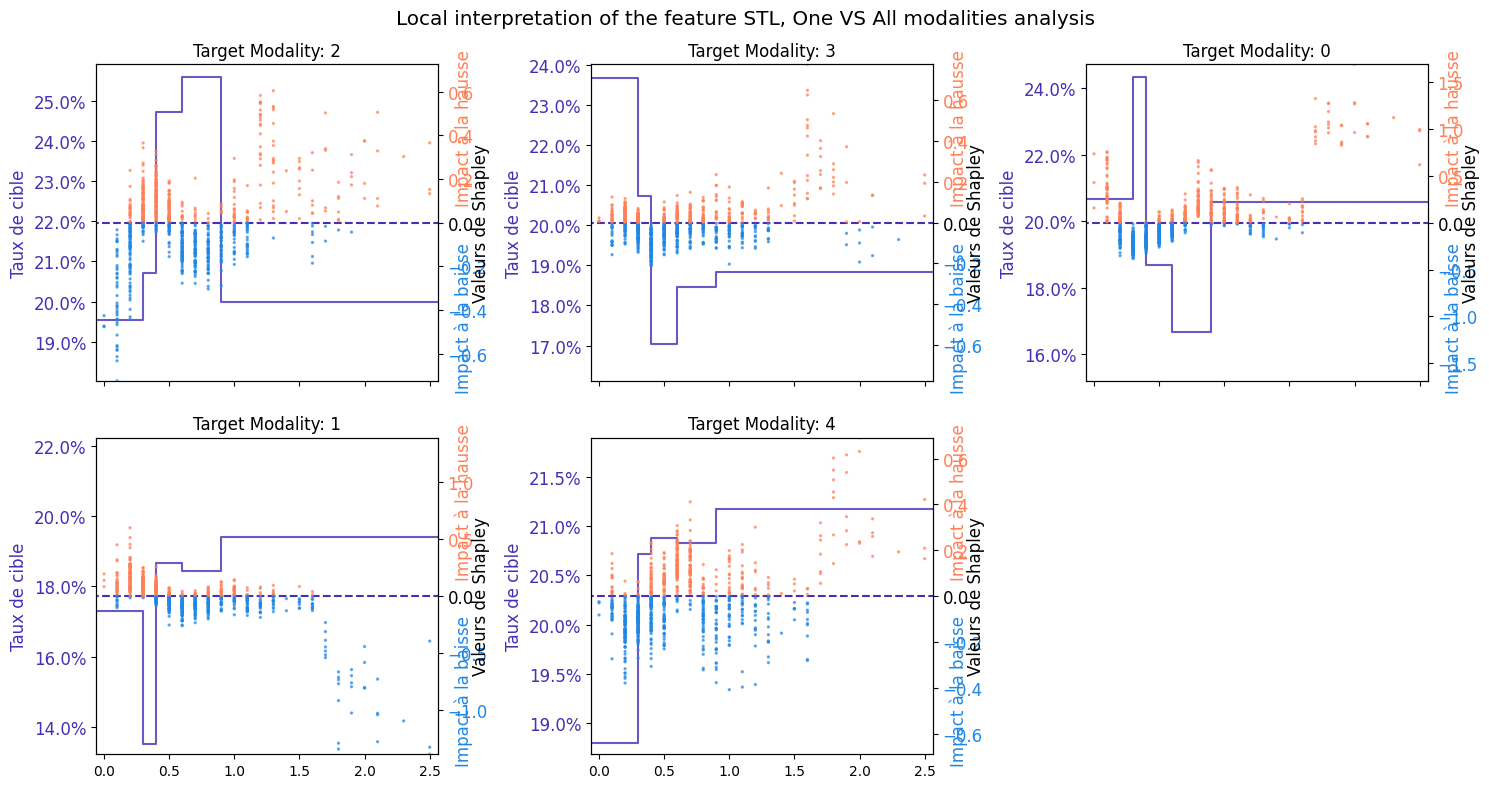

[Text(1, -0.4, '−0.4'), Text(1, -0.30000000000000004, '−0.3'), Text(1, -0.2, '−0.2'), Text(1, -0.09999999999999998, '−0.1'), Text(1, 0.0, '0.0'), Text(1, 0.09999999999999998, '0.1'), Text(1, 0.20000000000000007, '0.2'), Text(1, 0.30000000000000004, '0.3'), Text(1, 0.4, '0.4')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '

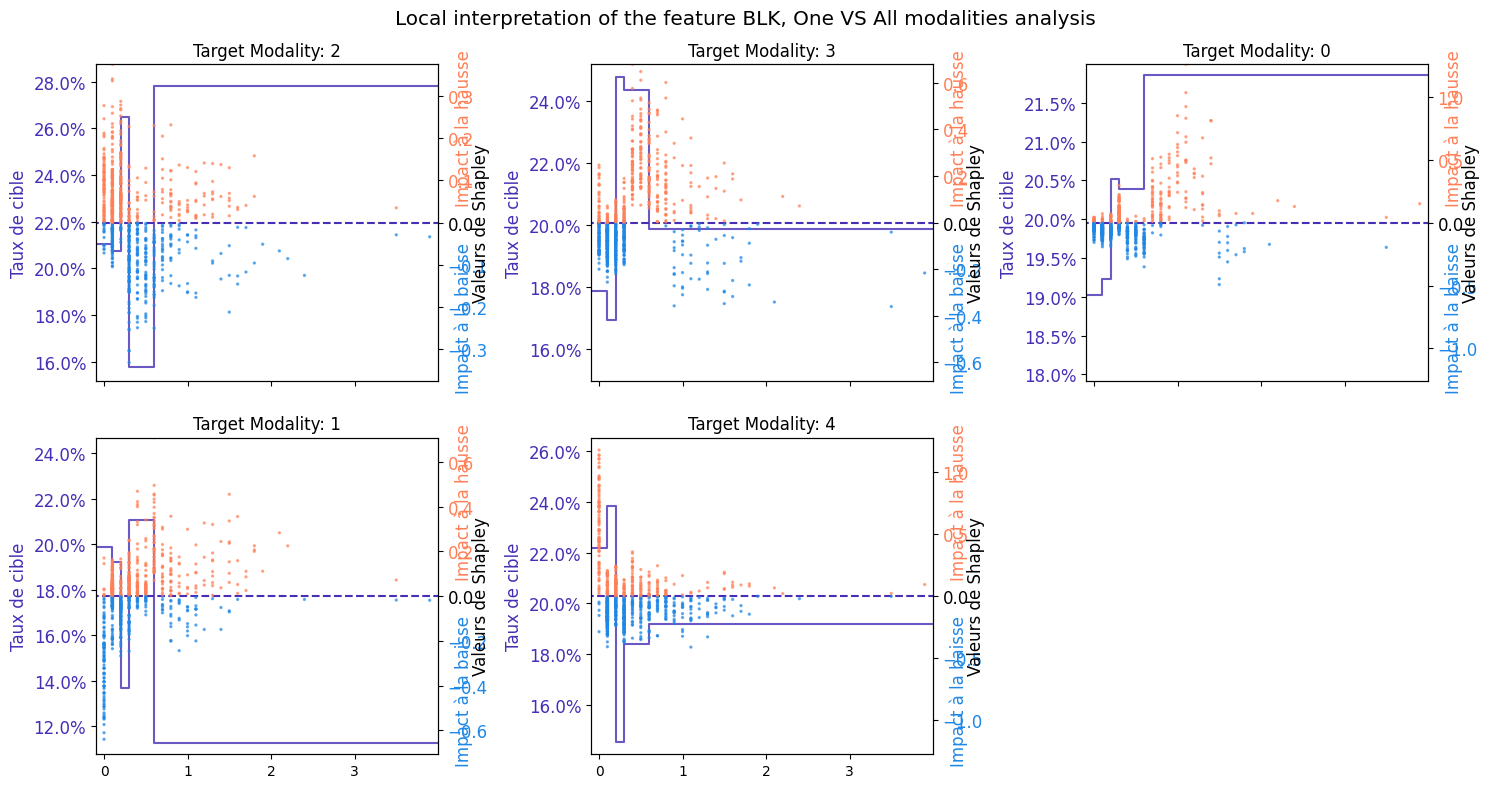

[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996

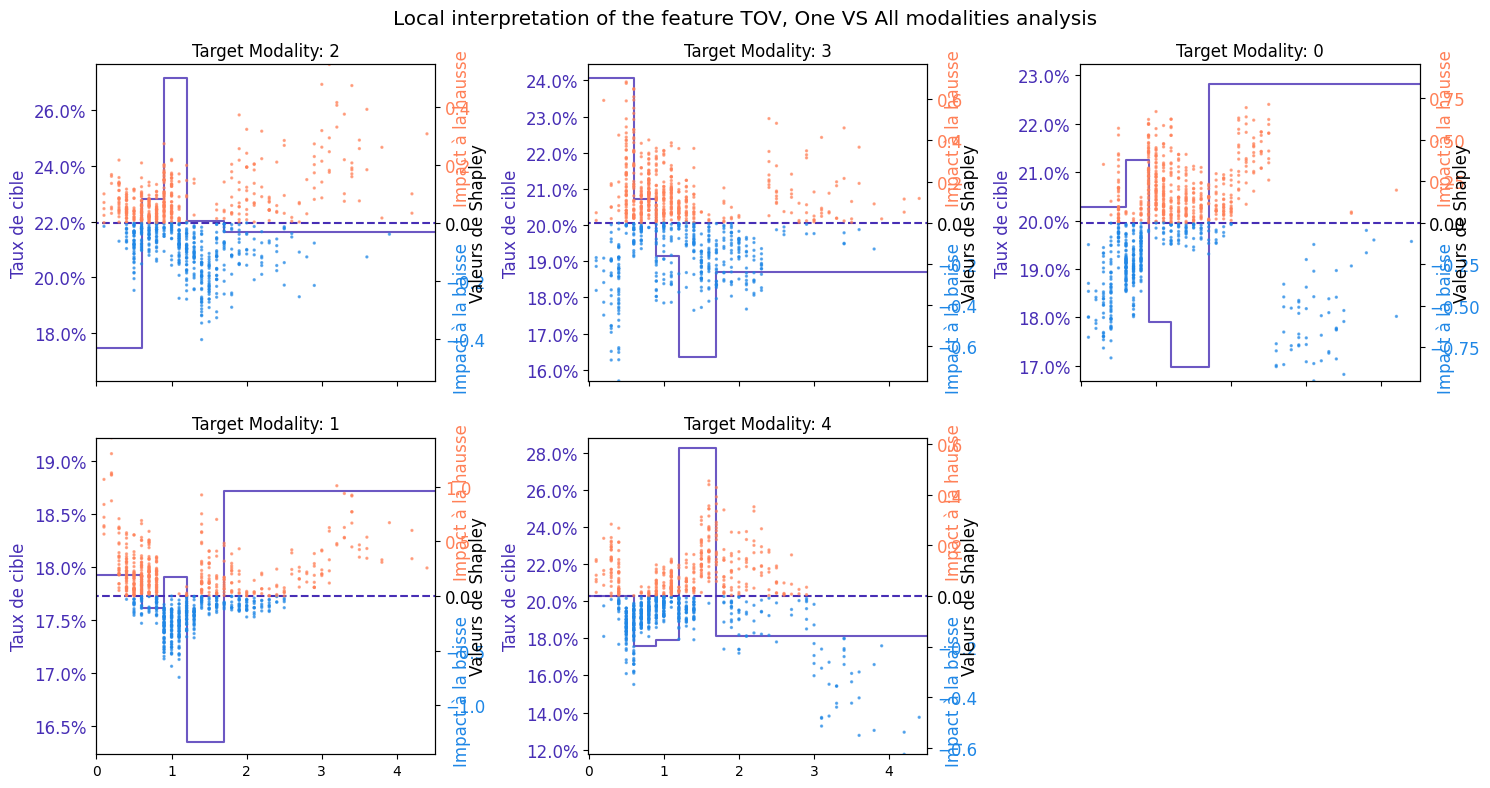

[Text(1, -1.0, '−1.00'), Text(1, -0.75, '−0.75'), Text(1, -0.5, '−0.50'), Text(1, -0.25, '−0.25'), Text(1, 0.0, '0.00'), Text(1, 0.25, '0.25'), Text(1, 0.5, '0.50'), Text(1, 0.75, '0.75'), Text(1, 1.0, '1.00')]
[Text(1, -0.2, '−0.20'), Text(1, -0.15000000000000002, '−0.15'), Text(1, -0.1, '−0.10'), Text(1, -0.04999999999999999, '−0.05'), Text(1, 0.0, '0.00'), Text(1, 0.04999999999999999, '0.05'), Text(1, 0.10000000000000003, '0.10'), Text(1, 0.15000000000000002, '0.15'), Text(1, 0.2, '0.20')]
[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -0.30000000000000004, '−0.3'), Text(1, -0.20000000000000004, '−0.2'), Text(1, -0.10000000000000003, '−0.1'), Text(1, 0.0, '0.0'), Text(1, 0.09999999999999998, '0.1'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.30000000000000004, '0.3')]
[Text(

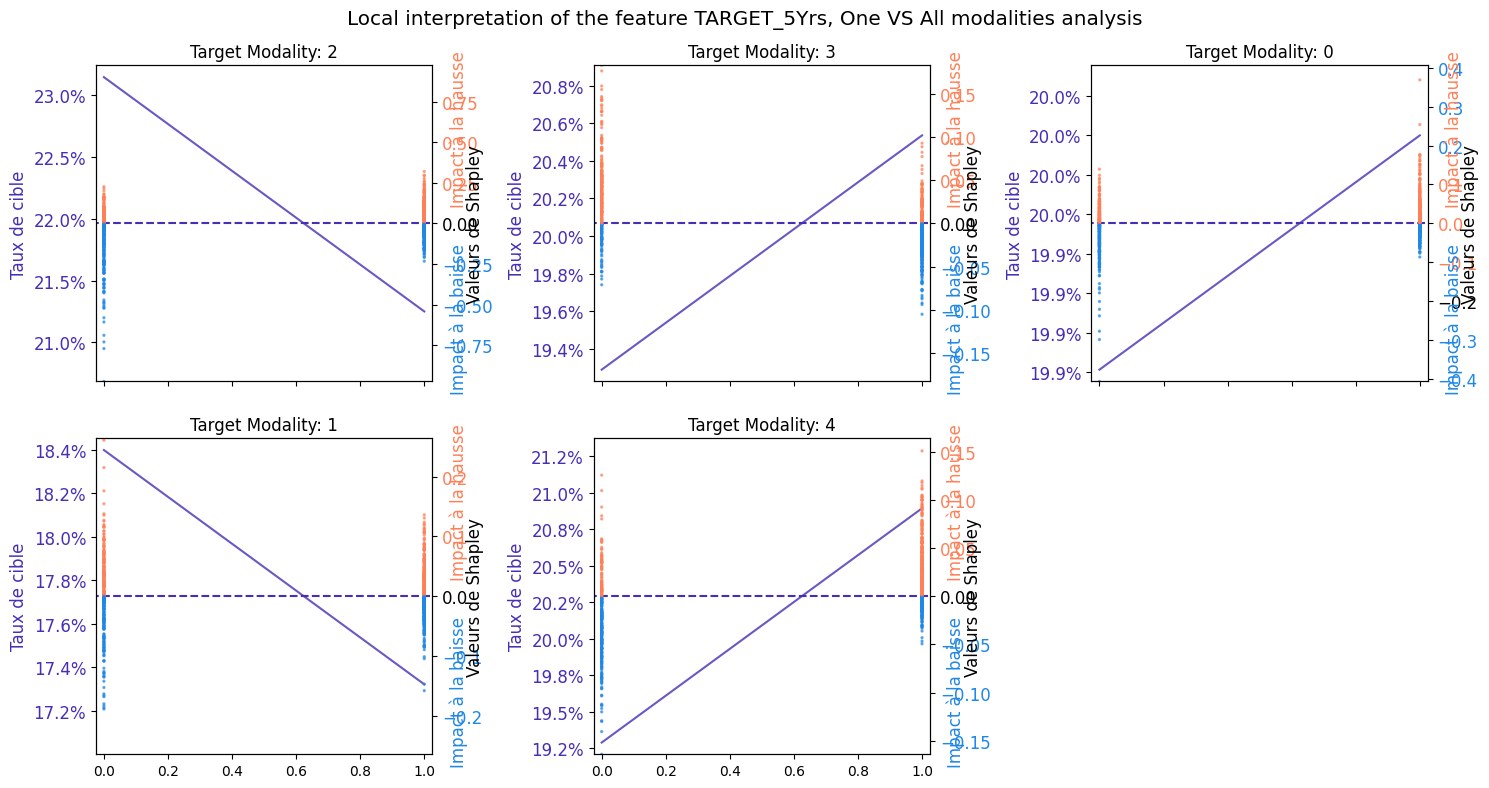

[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -0.8, '−0.8'), Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4, '−0.4'), Text(1, -0.19999999999999996, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.40000000000000013, '0.4'), Text(1, 0.6000000000000001, '0.6'), Text(1, 0.8, '0.8')]
[Text(1, -1.5, '−1

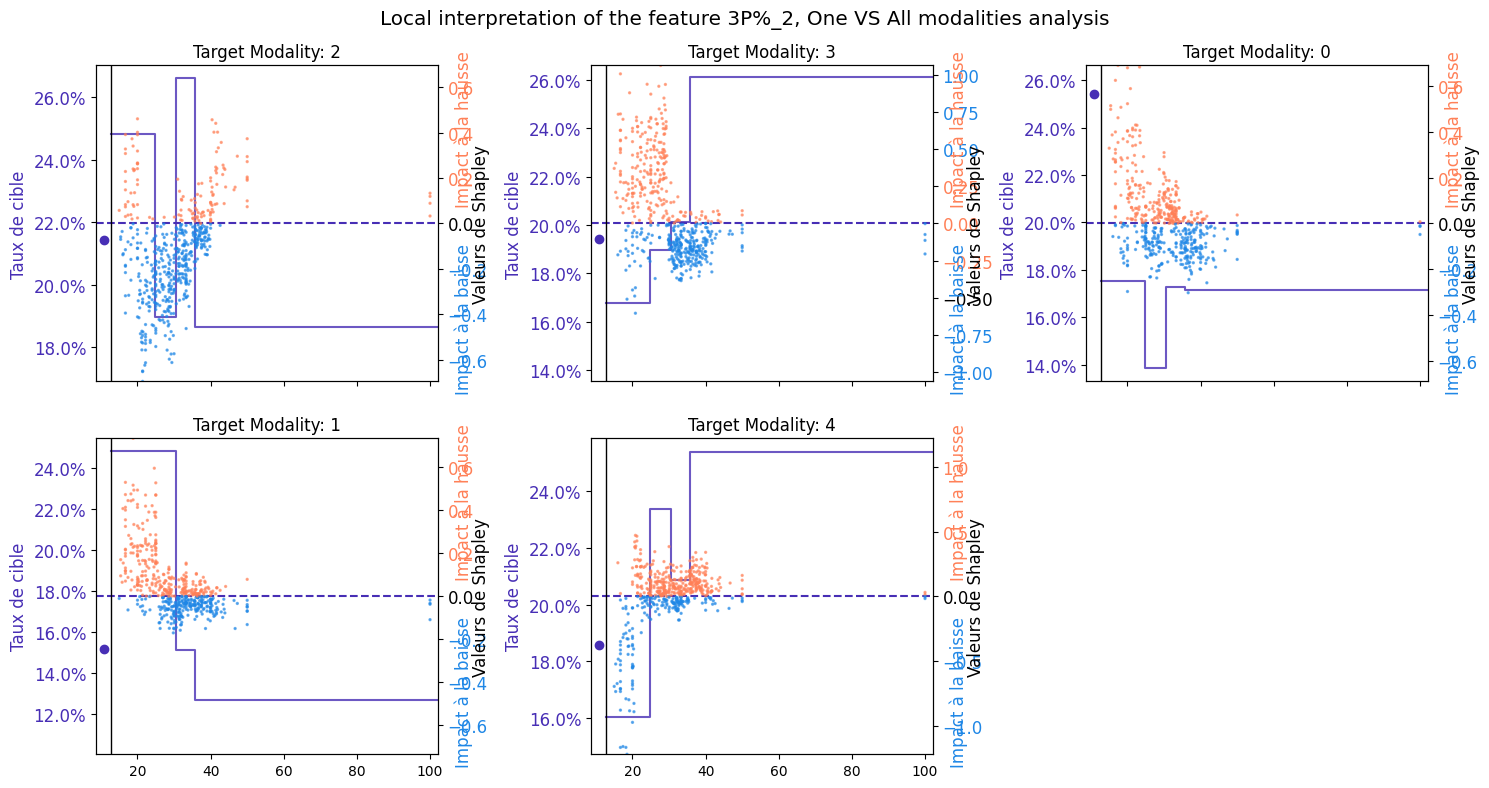

[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -0.6000000000000001, '−0.6'), Text(1, -0.4000000000000001, '−0.4'), Text(1, -0.20000000000000007, '−0.2'), Text(1, 0.0, '0.0'), Text(1, 0.19999999999999996, '0.2'), Text(1, 0.3999999999999999, '0.4'), Text(1, 0.6000000000000001, '0.6')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]
[Text(1, -1.5, '−1.5'), Text(1, -1.0, '−1.0'), Text(1, -0.5, '−0.5'), Text(1, 0.0, '0.0'), Text(1, 0.5, '0.5'), Text(1, 1.0, '1.0'), Text(1, 1.5, '1.5')]


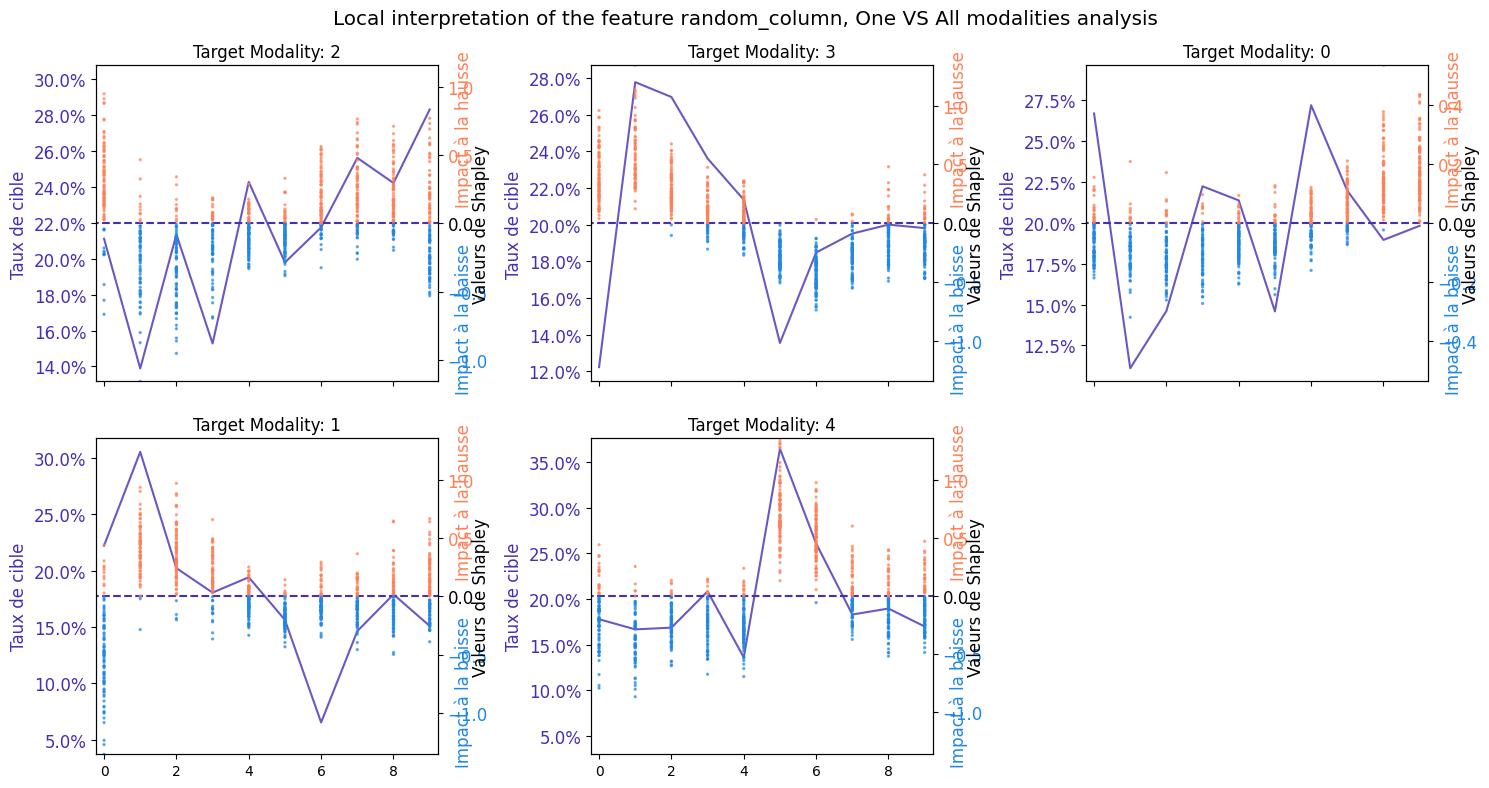

IndexError: index 23 is out of bounds for axis 1 with size 23

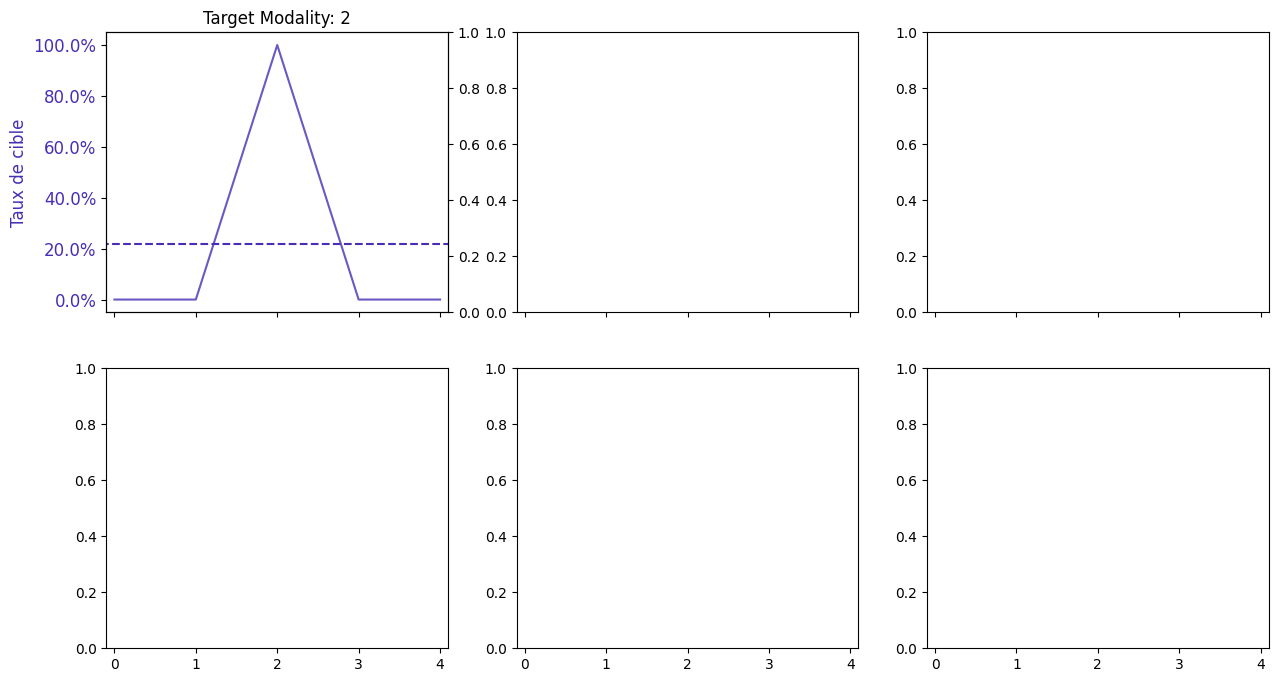

In [15]:
MultilabelMLExplainer(
    x_train=X_train,
    y_train=y_train,
    features=selected_features,
    model=model
).explain(q=5)

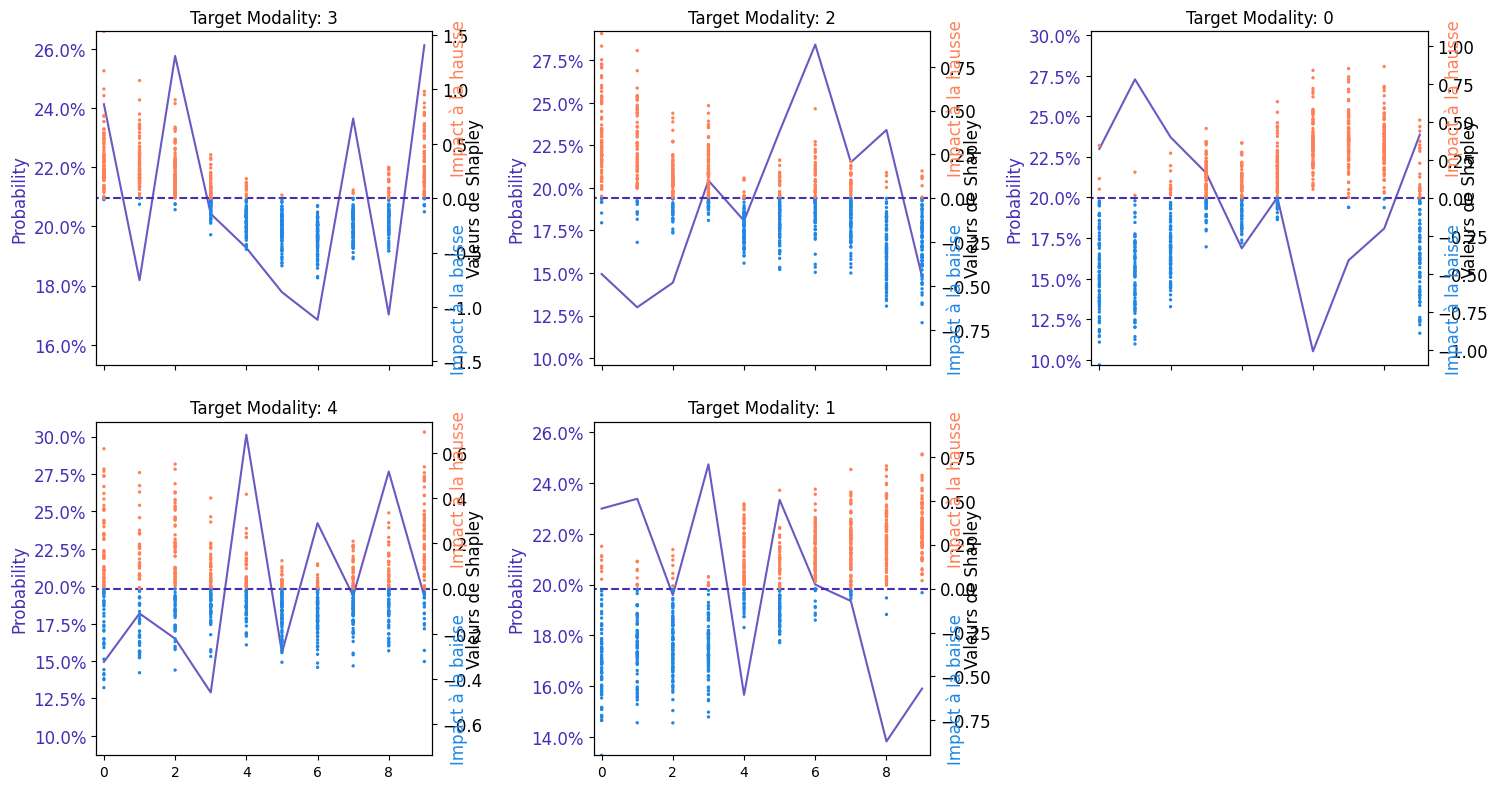

In [ ]:
import sys
sys.path.append("../mlexplainer")

from shap_explainer.multilabels_classification import feature_interpretation_multimodal, feature_interpretation_multimodal_category


feature_interpretation_multimodal('random_column', X_train, y_train, shap_values, q=5)

/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:169: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat_target.groupby("group", dropna=False)[target]
/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:177: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_feat_target.groupby("group", dropna=False)[target]
/Users/zachariebuisson/Documents/GitHub/mlexplainer/notebooks/../mlexplainer/shap_explainer/utils_shap_explainer/utils.py:169: FutureWarning: The default of obser

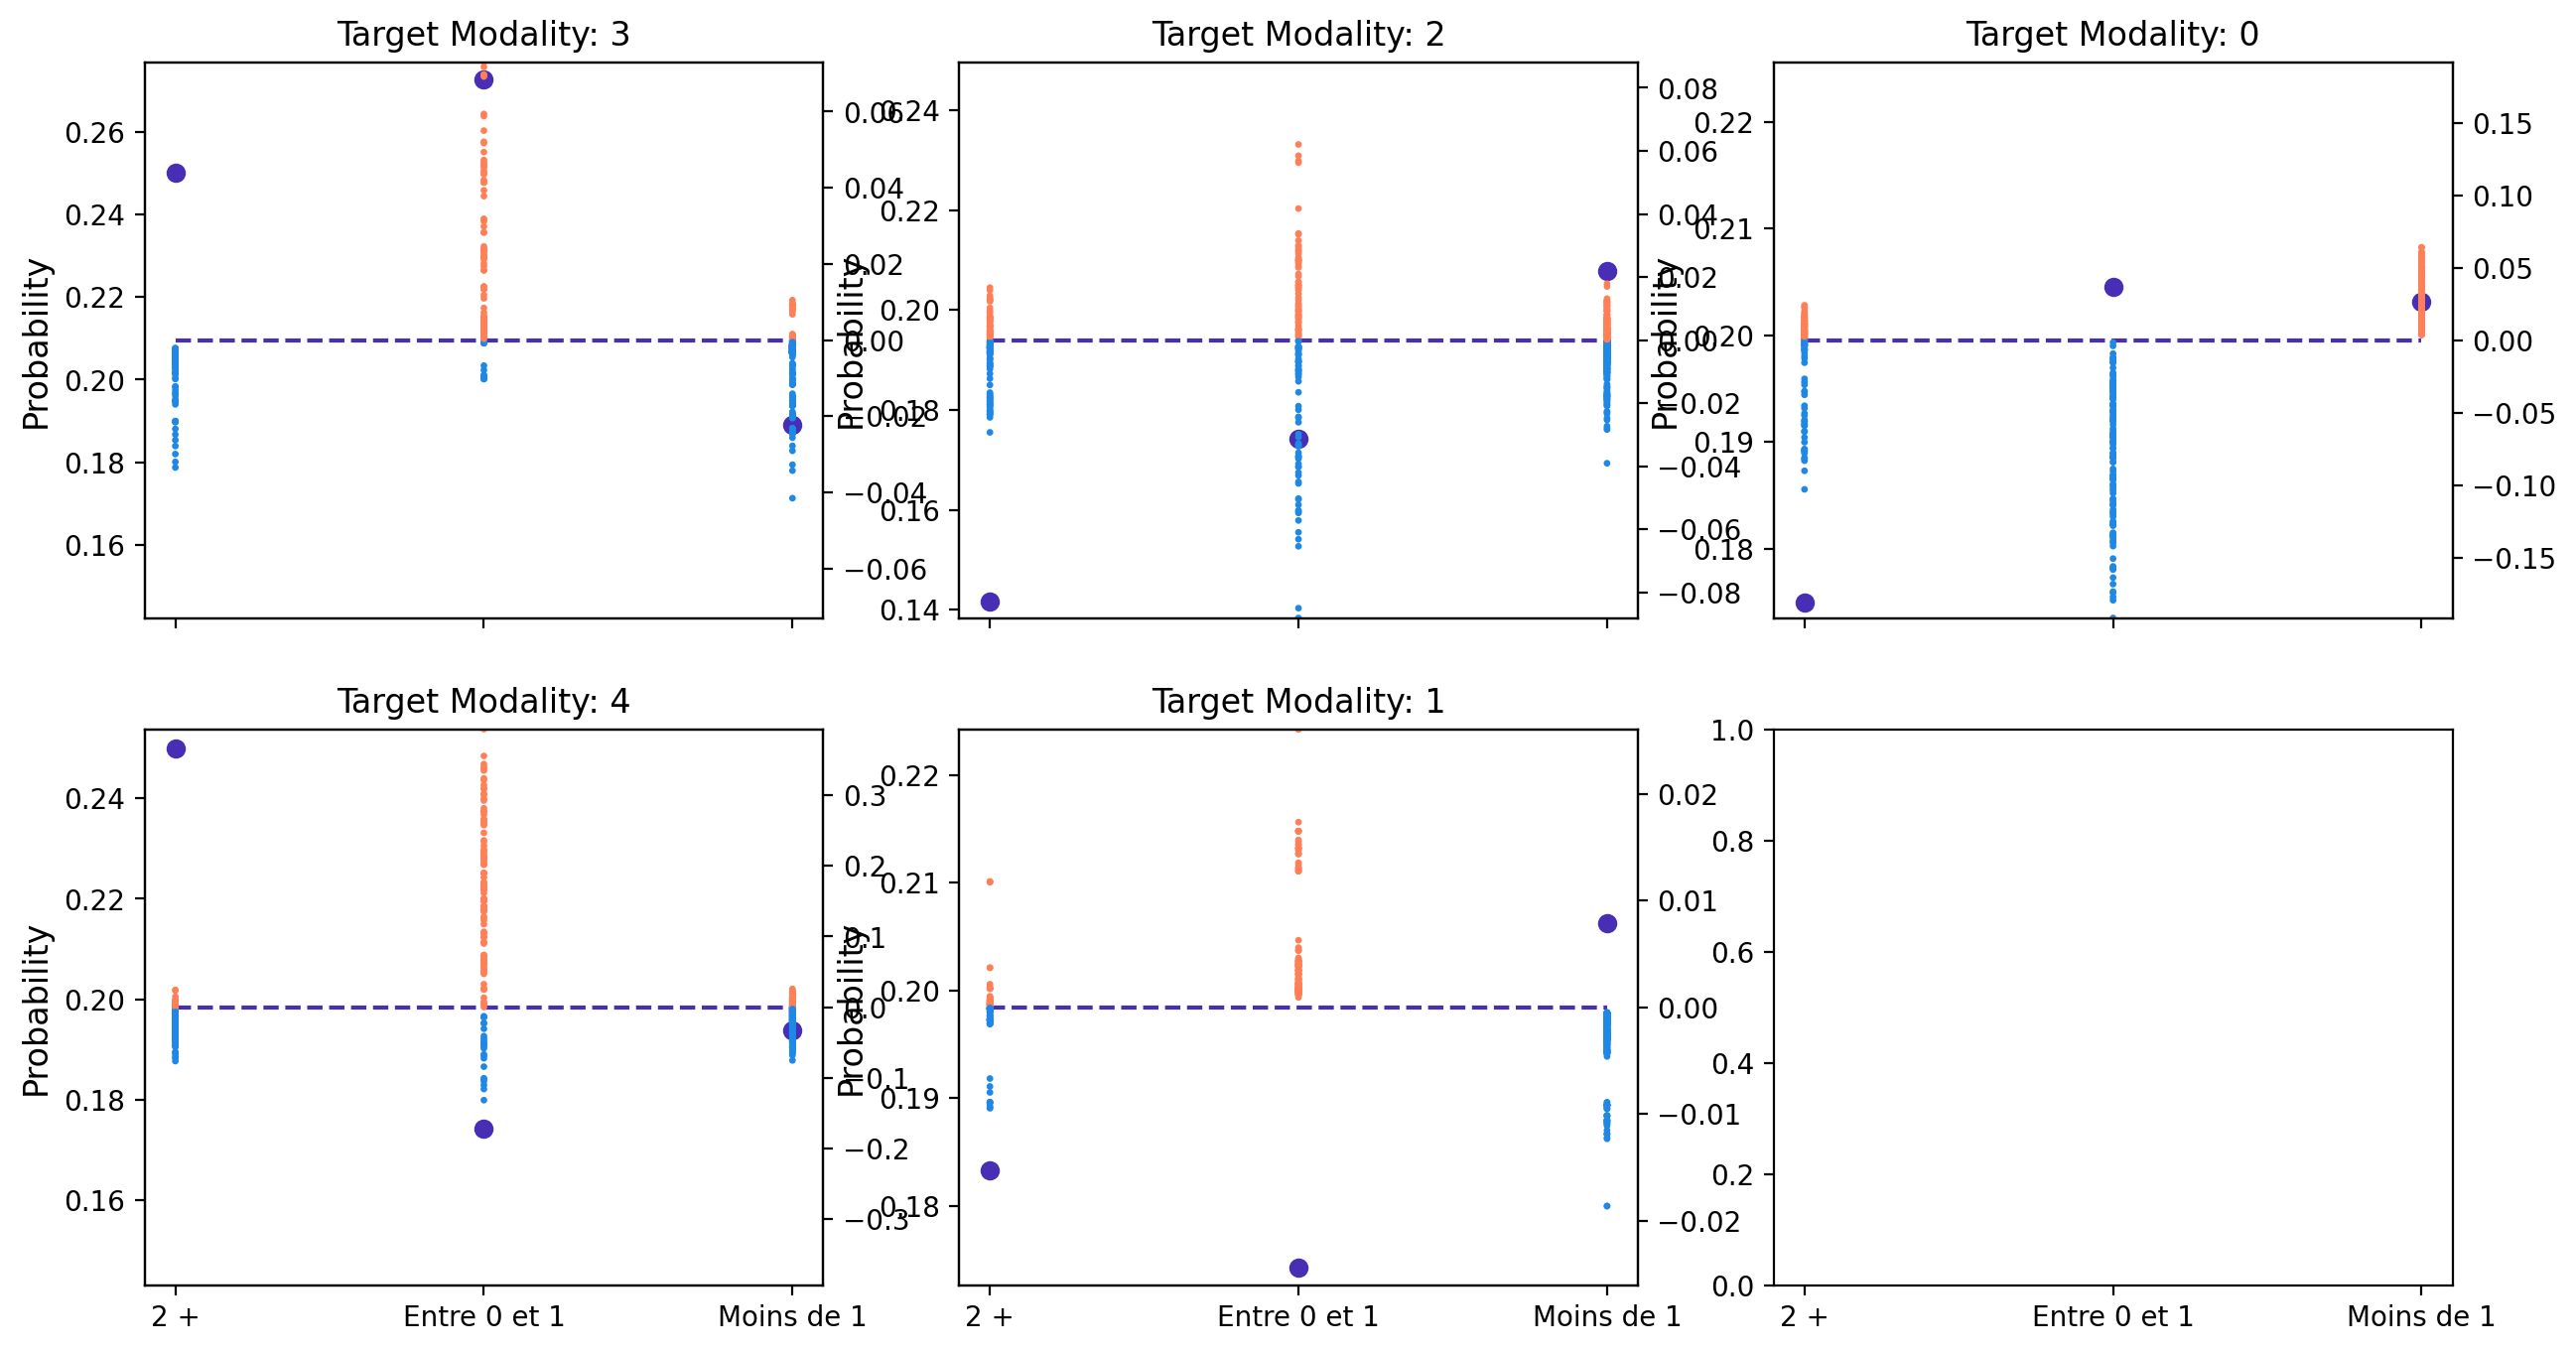

In [20]:
from shap_explainer.multilabels_classification import feature_interpretation_multimodal_category

feature_interpretation_multimodal_category('is_ok_3pts', X_train, y_train, 'random_feature', shap_values)